# Import Libraries

In [1]:
pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.stats as stats
from datetime import datetime as dt

from wordcloud import WordCloud, STOPWORDS

# To visualize the geographical coordinates in the world map
import folium
from folium.plugins import HeatMap

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

from sklearn.model_selection import train_test_split

import statsmodels
import statsmodels.api as sm

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
import lightgbm as lgb

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import tree

from sklearn.feature_selection import RFE

from warnings import filterwarnings
filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Upload Data

### Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/MyDrive/Final_Projek_Olist_Dataset/dataset/"

final= pd.read_csv(data_path+"final.csv")
final_outlierTreated = pd.read_csv(data_path + "finalOutlierTreated.csv")

### Local

In [ ]:
data_path = "../dataset/"

final= pd.read_csv(data_path+"final.csv")
final_outlierTreated = pd.read_csv(data_path + "finalOutlierTreated.csv")

In [5]:
final_outlierTreated.shape

(96096, 21)

In [6]:
final_outlierTreated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            96096 non-null  int64  
 1   customer_unique_id    96096 non-null  object 
 2   customer_city         96096 non-null  object 
 3   customer_state        96096 non-null  object 
 4   purchased_approved    96096 non-null  float64
 5   delivered_estimated   96096 non-null  float64
 6   purchased_delivered   96096 non-null  float64
 7   price                 96096 non-null  float64
 8   freight_value         96096 non-null  float64
 9   product_weight_g      96096 non-null  float64
 10  product_length_cm     96096 non-null  float64
 11  product_height_cm     96096 non-null  float64
 12  product_width_cm      96096 non-null  float64
 13  geolocation_lat       96096 non-null  float64
 14  geolocation_lng       96096 non-null  float64
 15  payment_type       

# Churn Classification

## Checking Imbalance

In [ ]:
final_outlierTreated.Churn.value_counts(normalize = True) * 100

,proportion
Churn,
0,54.817058
1,45.182942


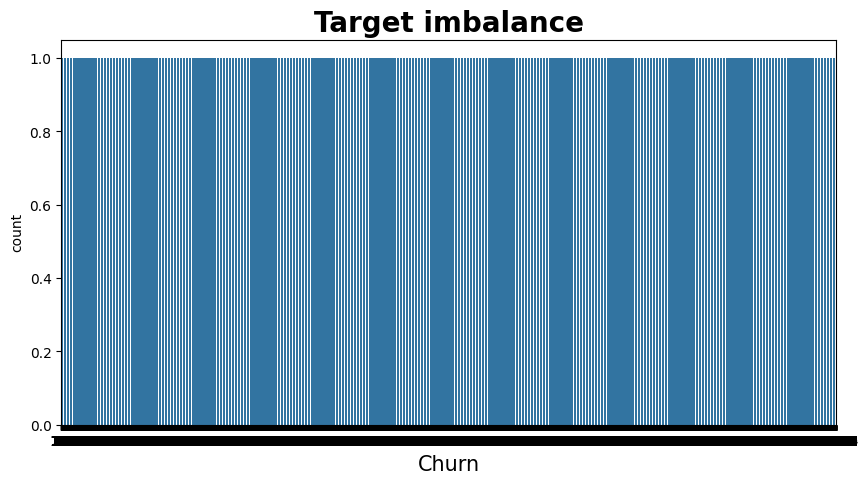

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(final_outlierTreated.Churn)
plt.xlabel('Churn',color='black',fontsize=15)
plt.title('Target imbalance',color='black',fontsize=20,fontweight='bold')
plt.show()

*Insight*:

The data is fairly balanced, with 54.82% non-churn and 45.18% churn, so no major class imbalance issues.

## Multicolinearity Analysis

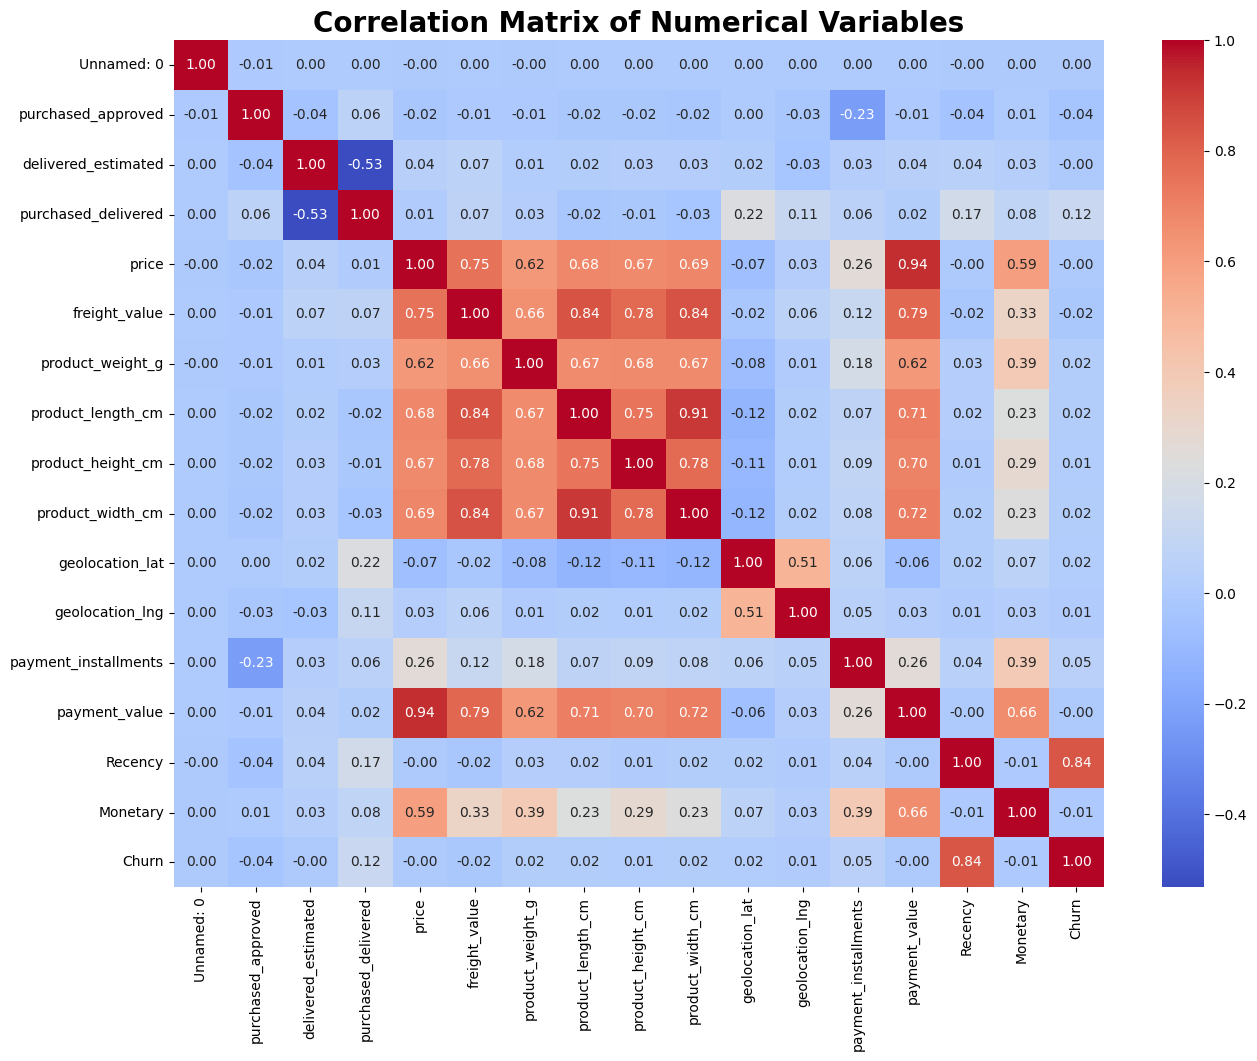

In [ ]:
plt.figure(figsize=(15,11))
sns.heatmap(final_outlierTreated.select_dtypes(include=['number']).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Variables", fontsize=20, fontweight="bold")
plt.show()


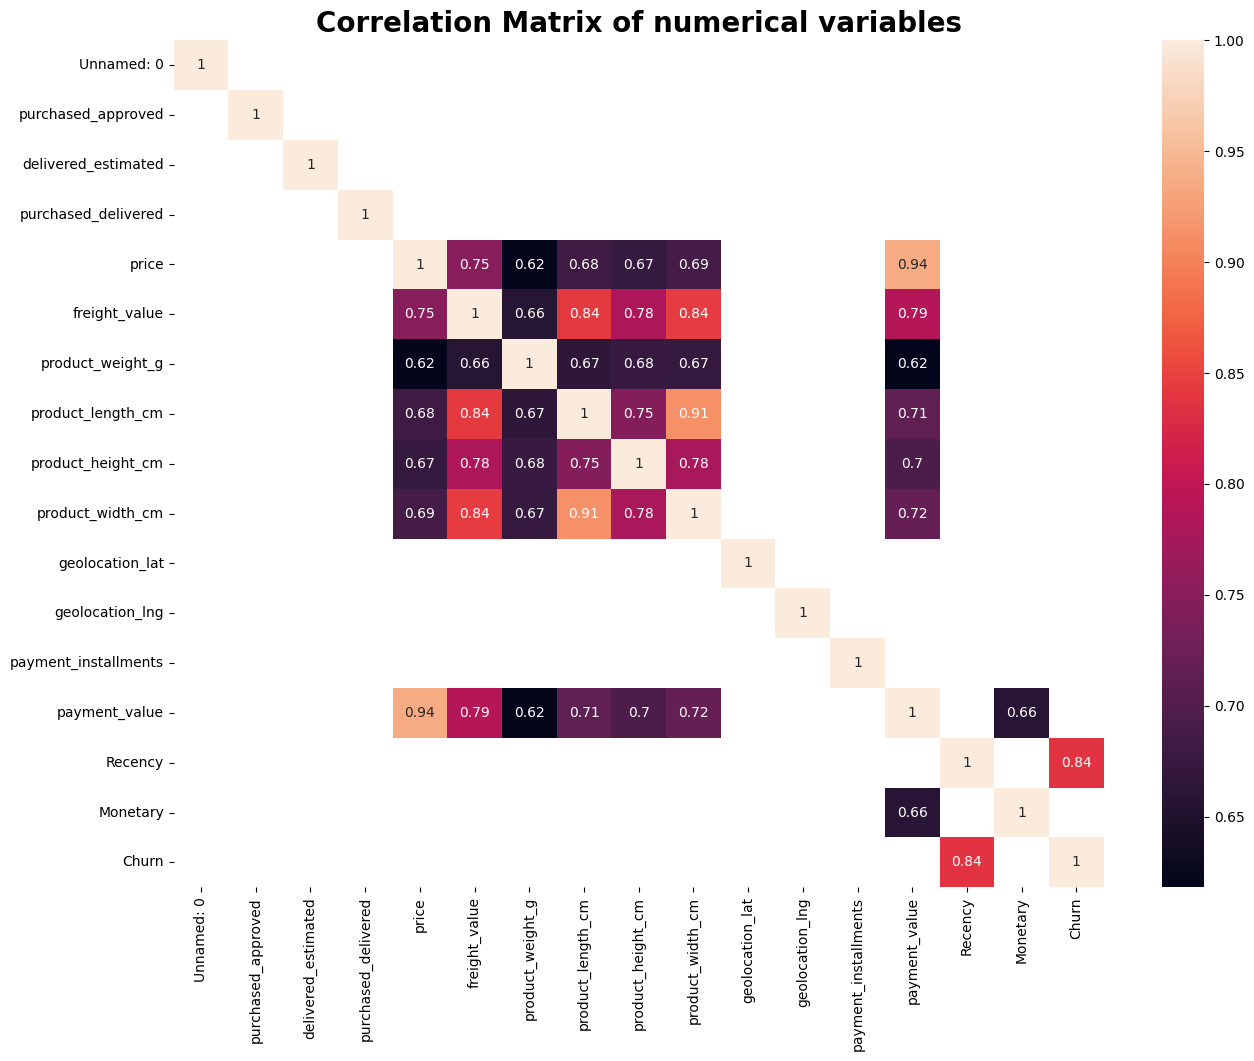

In [ ]:
plt.figure(figsize=(15,11))
sns.heatmap(final_outlierTreated.select_dtypes(include=['number']).corr()[final_outlierTreated.select_dtypes(include=['number']).corr() > 0.6], annot = True)
plt.title('Correlation Matrix of numerical variables',fontsize=20,fontweight='bold')
plt.show()

*Insight*

High Correlation Between Some Variables:

- price and freight_value (0.75): Higher product prices tend to have higher shipping costs.

- product_length_cm, product_width_cm, and product_height_cm show strong correlations with each other and with freight_value (0.84), meaning product dimensions are closely related.

- payment_value and payment_installments (0.94): Total payment value and number of installments are highly correlated, which may cause redundancy in the model.
- Monetary and Recency (0.84): Customers who have spent more tend to have more recent transactions.

## Statistical Test

In [ ]:
def cat_cat(variable):
    dependent_variables = []
    independent_variables = []
    for var in variable:
        print(f'{var} and Churn')
        observed = pd.crosstab(final_outlierTreated[var], final_outlierTreated.Churn)
        chi_stats, pval, dof, expected = stats.chi2_contingency(observed)
        print('test statistics: ', chi_stats)
        print('p - value: ', pval)
        print('degrees of freedom: ', dof)
        if pval < 0.05:
            print(f'Reject Null Hypothesis. \nThe variables {var} and target variable, Churn are dependent.\n')
            dependent_variables.append(var)
        else:
            print(f'Failed to reject Null Hypothesis. \nThe variables {var} and target variable, Churn are independent.\n')
            independent_variables.append(var)
    print('Dependent variables: ', dependent_variables)
    print('Independent variables: ', independent_variables)

variable = ['customer_state', 'payment_type', 'payment_installments', 'customer_city']
cat_cat(variable)

customer_state and Churn
test statistics:  330.8249136657987
p - value:  1.3716824913845916e-54
degrees of freedom:  26
Reject Null Hypothesis. 
The variables customer_state and target variable, Churn are dependent.

payment_type and Churn
test statistics:  283.44540697070926
p - value:  4.028143925695682e-60
degrees of freedom:  4
Reject Null Hypothesis. 
The variables payment_type and target variable, Churn are dependent.

payment_installments and Churn
test statistics:  550.3554589698286
p - value:  9.340531332765688e-113
degrees of freedom:  9
Reject Null Hypothesis. 
The variables payment_installments and target variable, Churn are dependent.

customer_city and Churn
test statistics:  4637.440330116479
p - value:  1.8290521523330248e-08
degrees of freedom:  4118
Reject Null Hypothesis. 
The variables customer_city and target variable, Churn are dependent.

Dependent variables:  ['customer_state', 'payment_type', 'payment_installments', 'customer_city']
Independent variables:  []


In [ ]:
def num_cat(variable):
    correlated_variables = []
    noncorrelated_variables = []
    for var in variable:
        print(f'{var} Vs. target variable, Churn')
        churn = final_outlierTreated[final_outlierTreated.Churn == 1][var]
        not_churn = final_outlierTreated[final_outlierTreated.Churn == 0][var]
        test_stats, churn_pval = stats.shapiro(churn)
        test_stats, notchurn_pval = stats.shapiro(not_churn)
        if churn_pval < 0.05:
            print(f'churn of {var} is not normal')
        else:
            print(f'churn of {var} is normal')
        if notchurn_pval < 0.05:
            print(f'not churn of {var} is not normal')
        else:
            print(f'not churn of {var} is normal')
        levene_teststats, pval_levene = stats.levene(churn, not_churn)
        if pval_levene < 0.05:
            print(f'atleast one variance is not equal')
        else:
            print(f'all variances are equal')
        anova_teststats, pval_anova = stats.f_oneway(churn, not_churn)
        if pval_anova < 0.05:
            print(f'Reject Null Hypothesis. \nThe variables {var} and target variable, Churn are correlated with each other.\n')
            correlated_variables.append(var)
        else:
            print(f'Failed to reject Null Hypothesis. \nThe variables {var} and target variable, Churn are not correlated with each other.\n')
            noncorrelated_variables.append(var)

    print('Correlated variables: ', correlated_variables)
    print('Non-correlated variables: ', noncorrelated_variables)


variable = ['purchased_approved', 'delivered_estimated', 'purchased_delivered', 'price', 'freight_value', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'geolocation_lat', 'geolocation_lng', 'Recency', 'Monetary']
num_cat(variable)

purchased_approved Vs. target variable, Churn
churn of purchased_approved is not normal
not churn of purchased_approved is not normal
atleast one variance is not equal
Reject Null Hypothesis. 
The variables purchased_approved and target variable, Churn are correlated with each other.

delivered_estimated Vs. target variable, Churn
churn of delivered_estimated is not normal
not churn of delivered_estimated is not normal
atleast one variance is not equal
Failed to reject Null Hypothesis. 
The variables delivered_estimated and target variable, Churn are not correlated with each other.

purchased_delivered Vs. target variable, Churn
churn of purchased_delivered is not normal
not churn of purchased_delivered is not normal
atleast one variance is not equal
Reject Null Hypothesis. 
The variables purchased_delivered and target variable, Churn are correlated with each other.

price Vs. target variable, Churn
churn of price is not normal
not churn of price is not normal
all variances are equal
F

In [ ]:
def non_parametric_tests(variable):
    correlated_variables = []
    noncorrelated_variables = []
    for var in variable:
        test_stats, pval = stats.mannwhitneyu(final_outlierTreated[final_outlierTreated.Churn == 1][var], final_outlierTreated[final_outlierTreated.Churn == 0][var])
        if pval < 0.05:
            print(f'Reject Null Hypothesis. \nThe variables {var} and target variable, Churn are correlated with each other.\n')
            correlated_variables.append(var)
        else:
            print(f'Failed to reject Null Hypothesis. \nThe variables {var} and target variable, Churn are not correlated with each other.\n')
            noncorrelated_variables.append(var)
    print(f'Correlated variables: ', correlated_variables)
    print(f'Non correlated variables: ', noncorrelated_variables)

variable = ['purchased_approved', 'delivered_estimated', 'purchased_delivered', 'price', 'freight_value', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'geolocation_lat', 'geolocation_lng', 'Recency', 'Monetary']
non_parametric_tests(variable)

Reject Null Hypothesis. 
The variables purchased_approved and target variable, Churn are correlated with each other.

Reject Null Hypothesis. 
The variables delivered_estimated and target variable, Churn are correlated with each other.

Reject Null Hypothesis. 
The variables purchased_delivered and target variable, Churn are correlated with each other.

Reject Null Hypothesis. 
The variables price and target variable, Churn are correlated with each other.

Reject Null Hypothesis. 
The variables freight_value and target variable, Churn are correlated with each other.

Reject Null Hypothesis. 
The variables product_weight_g and target variable, Churn are correlated with each other.

Reject Null Hypothesis. 
The variables product_length_cm and target variable, Churn are correlated with each other.

Failed to reject Null Hypothesis. 
The variables product_height_cm and target variable, Churn are not correlated with each other.

Reject Null Hypothesis. 
The variables product_width_cm and ta

*Insight*:

Dependent Variables

- Customer state, payment type, payment installments, and customer city significantly influence churn.
- These categorical variables should be considered in predictive modeling.

Correlated Variables

- Features like purchased_approved, purchased_delivered, freight_value, product dimensions (weight, length, width, height), geolocation (lat, lng), Recency, and Monetary value are strongly correlated with churn.

- These indicate that purchasing behavior, delivery times, and product-related factors play a role in customer retention.

Non-Correlated Variables

- Delivered_estimated and price do not significantly impact churn.
- This suggests that estimated delivery time and product pricing may not be major factors in customer churn.

## Transform Data

In [7]:
if 'Unnamed: 0' in final_outlierTreated.columns:
    final_outlierTreated = final_outlierTreated.drop(columns=['Unnamed: 0'])

In [8]:

transformed_data = final_outlierTreated.copy()

transformed_data['Churn'] = transformed_data['Churn'].astype(int)


In [9]:
# Compute skewness only for numeric columns
skew_values = transformed_data.select_dtypes(include=['number']).skew()
print(skew_values)

purchased_approved      1.230523
delivered_estimated    -0.093415
purchased_delivered     0.654754
price                   1.166370
freight_value           1.133494
product_weight_g        1.192593
product_length_cm       1.132339
product_height_cm       1.155420
product_width_cm        1.125868
geolocation_lat         0.528843
geolocation_lng         0.266284
payment_installments    1.213195
payment_value           1.163934
Recency                 0.445331
Monetary                1.094696
Churn                   0.193586
dtype: float64


In [10]:
transformed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_unique_id    96096 non-null  object 
 1   customer_city         96096 non-null  object 
 2   customer_state        96096 non-null  object 
 3   purchased_approved    96096 non-null  float64
 4   delivered_estimated   96096 non-null  float64
 5   purchased_delivered   96096 non-null  float64
 6   price                 96096 non-null  float64
 7   freight_value         96096 non-null  float64
 8   product_weight_g      96096 non-null  float64
 9   product_length_cm     96096 non-null  float64
 10  product_height_cm     96096 non-null  float64
 11  product_width_cm      96096 non-null  float64
 12  geolocation_lat       96096 non-null  float64
 13  geolocation_lng       96096 non-null  float64
 14  payment_type          96096 non-null  object 
 15  payment_installment

In [11]:
pt = PowerTransformer(method = 'yeo-johnson')
for var in transformed_data:
    if var in ['delivered_estimated','geolocation_lat','geolocation_lng']:
        transformed_data[var] = pt.fit_transform(transformed_data[[var]])

In [12]:
# Compute skewness only for numeric columns
skew_values = transformed_data.select_dtypes(include=['number']).skew()
print(skew_values)

purchased_approved      1.230523
delivered_estimated     0.105415
purchased_delivered     0.654754
price                   1.166370
freight_value           1.133494
product_weight_g        1.192593
product_length_cm       1.132339
product_height_cm       1.155420
product_width_cm        1.125868
geolocation_lat         0.032510
geolocation_lng        -0.012893
payment_installments    1.213195
payment_value           1.163934
Recency                 0.445331
Monetary                1.094696
Churn                   0.193586
dtype: float64


*Insight:*

The variables which have negative values are transformed using yeo-johnson method, as log of 0 or negative values would return infinite value.


## Classification Models

### Final Data Preparation

In [13]:
transformed_data.head()

,customer_unique_id,customer_city,customer_state,purchased_approved,delivered_estimated,purchased_delivered,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat,geolocation_lng,payment_type,payment_installments,payment_value,Recency,Monetary,Churn
0,0000366f3b9a7992bf8c76cfdf3221e2,cajamar,SP,891.0,-0.814954,6.0,8573.40,792.00,99000.000,2244.0,462.0,2112.0,-0.332955,-0.140237,credit_card,8.0,9365.40,160.0,141.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,osasco,SP,26057.0,-0.814954,3.0,2721.60,1193.76,54000.000,3744.0,1584.0,2592.0,-0.401034,-0.128703,credit_card,1.0,3915.36,163.0,27.19,0
2,0000f46a3911fa3c0805444483337064,sao jose,SC,0.0,-1.143277,25.0,8073.00,2014.74,175500.000,2925.0,5850.0,4095.0,-1.764318,-0.639017,credit_card,8.0,10087.74,586.0,86.22,1
3,0000f6ccb0745a6a4b88665a16c9f078,belem,PA,1176.0,-0.014016,20.0,831.68,564.16,4800.000,608.0,160.0,352.0,1.757607,-0.596739,credit_card,4.0,1395.84,370.0,43.62,1
4,0004aac84e0df4da2b147fca70cf8255,sorocaba,SP,1270.0,-0.475934,13.0,23940.00,2246.37,664736.875,2128.0,399.0,1463.0,-0.384308,-0.314996,credit_card,6.0,26186.37,337.0,196.89,1


In [14]:
def state_encoding(state):
    if state in ['RS', 'SC', 'PR']:
        return 'southern'
    elif state in ['SP', 'RJ', 'MG', 'ES']:
        return 'southeastern'
    elif state in ['MT', 'MS', 'GO', 'DF']:
        return 'centralwestern'
    elif state in ['MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA']:
        return 'northeastern'
    else:
        return 'northern'

In [15]:
transformed_data['customer_state'] = transformed_data['customer_state'].apply(state_encoding)

In [16]:
features = transformed_data.copy()
features.head()

,customer_unique_id,customer_city,customer_state,purchased_approved,delivered_estimated,purchased_delivered,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat,geolocation_lng,payment_type,payment_installments,payment_value,Recency,Monetary,Churn
0,0000366f3b9a7992bf8c76cfdf3221e2,cajamar,southeastern,891.0,-0.814954,6.0,8573.40,792.00,99000.000,2244.0,462.0,2112.0,-0.332955,-0.140237,credit_card,8.0,9365.40,160.0,141.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,osasco,southeastern,26057.0,-0.814954,3.0,2721.60,1193.76,54000.000,3744.0,1584.0,2592.0,-0.401034,-0.128703,credit_card,1.0,3915.36,163.0,27.19,0
2,0000f46a3911fa3c0805444483337064,sao jose,southern,0.0,-1.143277,25.0,8073.00,2014.74,175500.000,2925.0,5850.0,4095.0,-1.764318,-0.639017,credit_card,8.0,10087.74,586.0,86.22,1
3,0000f6ccb0745a6a4b88665a16c9f078,belem,northern,1176.0,-0.014016,20.0,831.68,564.16,4800.000,608.0,160.0,352.0,1.757607,-0.596739,credit_card,4.0,1395.84,370.0,43.62,1
4,0004aac84e0df4da2b147fca70cf8255,sorocaba,southeastern,1270.0,-0.475934,13.0,23940.00,2246.37,664736.875,2128.0,399.0,1463.0,-0.384308,-0.314996,credit_card,6.0,26186.37,337.0,196.89,1


In [17]:
features.drop(columns = ['customer_unique_id', 'customer_city', 'payment_value'], axis = 1, inplace = True)

In [18]:
features.head(1)

,customer_state,purchased_approved,delivered_estimated,purchased_delivered,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat,geolocation_lng,payment_type,payment_installments,Recency,Monetary,Churn
0,southeastern,891.0,-0.814954,6.0,8573.4,792.0,99000.0,2244.0,462.0,2112.0,-0.332955,-0.140237,credit_card,8.0,160.0,141.9,0


In [19]:
df_target = features['Churn'].astype('int')

In [20]:
independent = features.drop(columns = ['Churn'], axis = 1)
df_numeric = independent.select_dtypes(include = np.number)
df_categorical = independent.select_dtypes(exclude = np.number)

In [21]:
encoded_data = pd.get_dummies(df_categorical, drop_first=True)

In [22]:
X = pd.concat([df_numeric, encoded_data], axis = 1)
X.drop(columns = ['Recency'], axis = 1, inplace = True)

In [23]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   purchased_approved           96096 non-null  float64
 1   delivered_estimated          96096 non-null  float64
 2   purchased_delivered          96096 non-null  float64
 3   price                        96096 non-null  float64
 4   freight_value                96096 non-null  float64
 5   product_weight_g             96096 non-null  float64
 6   product_length_cm            96096 non-null  float64
 7   product_height_cm            96096 non-null  float64
 8   product_width_cm             96096 non-null  float64
 9   geolocation_lat              96096 non-null  float64
 10  geolocation_lng              96096 non-null  float64
 11  payment_installments         96096 non-null  float64
 12  Monetary                     96096 non-null  float64
 13  customer_state_n

*Insight*:

- State Encoding: Customer states grouped into five regions to reduce dimensionality.
- Dropped Columns: Removed non-informative (customer_unique_id, customer_city, payment_value) and Recency (likely due to redundancy).
- Encoding: One-hot encoding applied to categorical features.
- Feature Scaling: StandardScaler used for normalization.


### Train-Test Splitting

In [25]:
X_train, X_test, y_train, y_test = train_test_split(sm.add_constant(X), df_target, random_state = 1000, test_size = 0.2)

# check the dimensions of the train & test subset using 'shape'
# print dimension of train set
print('X_train', X_train.shape)
print('y_train', y_train.shape)

# print dimension of test set
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (76876, 22)
y_train (76876,)
X_test (19220, 22)
y_test (19220,)


In [26]:
cols = ['test_accuracy', 'train_accuracy', 'test_precision', 'train_precision','test_recall','train_recall', 'test_kappa', 'train_kappa', 'f1_score','roc_auc_score']
model_evaluation = pd.DataFrame(columns=cols)

*Insight*:
- Data Splitting: The dataset is split into 80% training and 20% testing (test_size=0.2).
- Constant Added: sm.add_constant(X) includes an intercept term for regression models.
- Ensures Reproducibility: random_state=1000 makes the split consistent across runs.
- Balanced Shapes: Confirms correct feature-target separation and maintains dataset integrity for model training.

## Model Prediction

### Logistic Regression

In [27]:
logreg = sm.Logit(y_train, X_train).fit_regularized(method="l1", alpha=1.0)
print(logreg.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6640406493666212
            Iterations: 222
            Function evaluations: 222
            Gradient evaluations: 222
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                76876
Model:                          Logit   Df Residuals:                    76854
Method:                           MLE   Df Model:                           21
Date:                Tue, 25 Feb 2025   Pseudo R-squ.:                 0.03524
Time:                        17:46:42   Log-Likelihood:                -51046.
converged:                       True   LL-Null:                       -52910.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

In [28]:
print('Akaike information criterion (AIC):', logreg.aic)

Akaike information criterion (AIC): 102135.218810348


In [29]:
logreg.params

,0
const,-0.207537
purchased_approved,-0.240697
delivered_estimated,0.250348
purchased_delivered,0.438125
price,0.017121
freight_value,-0.539481
product_weight_g,0.035926
product_length_cm,0.203208
product_height_cm,0.096264
product_width_cm,0.196486


In [30]:
df_odds = pd.DataFrame(np.exp(logreg.params), columns= ['Odds'])
df_odds

,Odds
const,0.812583
purchased_approved,0.786080
delivered_estimated,1.284473
purchased_delivered,1.549799
price,1.017269
freight_value,0.583051
product_weight_g,1.036579
product_length_cm,1.225328
product_height_cm,1.101049
product_width_cm,1.217119


In [31]:
#train set
y_pred_prob_train = logreg.predict(X_train)
y_pred_train = [ 0 if x < 0.5 else 1 for x in y_pred_prob_train]

In [32]:
#test set
y_pred_prob = logreg.predict(X_test)
y_pred_prob.head()

,0
37826,0.568179
63475,0.412763
82838,0.461724
26910,0.441333
53722,0.476506


In [33]:
y_pred = [ 0 if x < 0.5 else 1 for x in y_pred_prob]
y_pred[0:5]

[1, 0, 0, 0, 0]

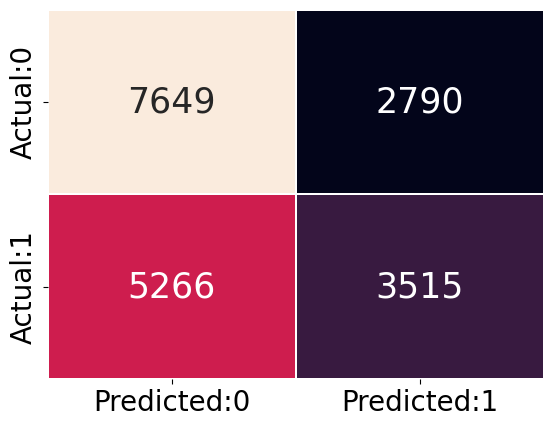

In [34]:
cm = confusion_matrix(y_test, y_pred)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False,
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [35]:
acc_table = classification_report(y_test, y_pred)
print(acc_table)

              precision    recall  f1-score   support

           0       0.59      0.73      0.66     10439
           1       0.56      0.40      0.47      8781

    accuracy                           0.58     19220
   macro avg       0.57      0.57      0.56     19220
weighted avg       0.58      0.58      0.57     19220



In [36]:
kappa = cohen_kappa_score(y_test, y_pred)
print('kappa value:',kappa)

kappa value: 0.13607619850655472


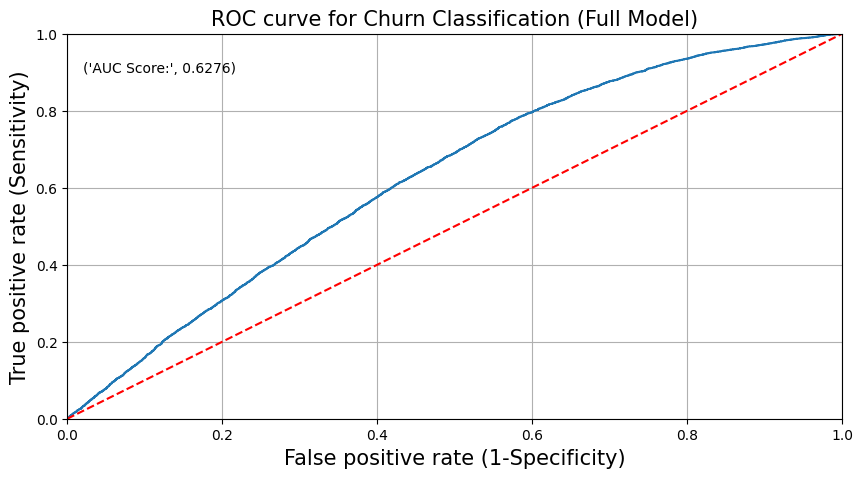

In [37]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve for Churn Classification (Full Model)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(y_test, y_pred_prob),4)))
plt.grid(True)

In [38]:
model_evaluation.loc['Logit_FullModel'] = [accuracy_score(y_test,y_pred), accuracy_score(y_train,y_pred_train),
                                          precision_score(y_test,y_pred), precision_score(y_train,y_pred_train),
                                          recall_score(y_test,y_pred), recall_score(y_train,y_pred_train),
                                          cohen_kappa_score(y_test,y_pred), cohen_kappa_score(y_train,y_pred_train),
                                          f1_score(y_test,y_pred), roc_auc_score(y_test,y_pred_prob)]
model_evaluation

,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_kappa,train_kappa,f1_score,roc_auc_score
Logit_FullModel,0.580853,0.586867,0.557494,0.55884,0.400296,0.394567,0.136076,0.142913,0.465995,0.627612


### Random Forest Classifier

In [39]:
xtrain_random, xtest_random, ytrain_random, ytest_random = train_test_split(X, df_target, test_size = 0.2, random_state = 500)
print('xtrain: ', xtrain_random.shape)
print('ytrain: ', ytrain_random.shape)
print('xtest: ', xtest_random.shape)
print('ytest: ', ytest_random.shape)

xtrain:  (76876, 21)
ytrain:  (76876,)
xtest:  (19220, 21)
ytest:  (19220,)


In [40]:
rand = RandomForestClassifier()
rand_model = rand.fit(xtrain_random,ytrain_random)

In [41]:
ypred_proba_random = rand_model.predict(xtest_random)

In [42]:
ypred_random = [0 if i < 0.5 else 1 for i in ypred_proba_random]
ypred_random[:10]

[0, 0, 0, 1, 1, 1, 1, 0, 0, 0]

In [43]:
ypred_proba_random_train = rand_model.predict(xtrain_random)
ypred_random_train = [0 if i < 0.5 else 1 for i in ypred_proba_random_train]

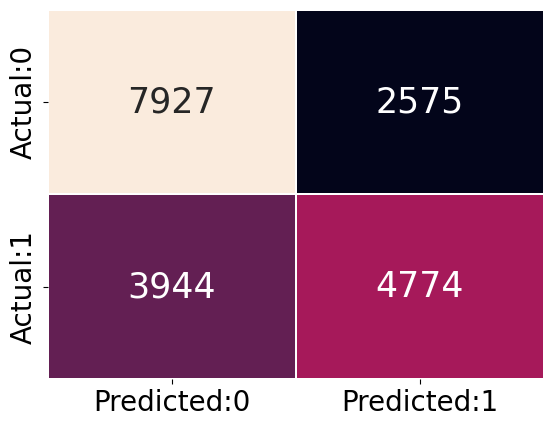

In [44]:
cm = confusion_matrix(ytest_random, ypred_random)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False,
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [45]:
print(classification_report(ytest_random, ypred_random))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71     10502
           1       0.65      0.55      0.59      8718

    accuracy                           0.66     19220
   macro avg       0.66      0.65      0.65     19220
weighted avg       0.66      0.66      0.66     19220



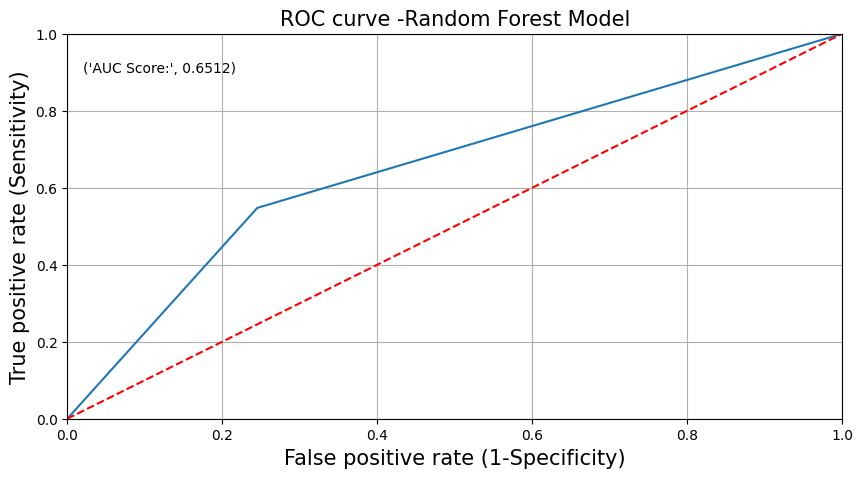

In [46]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(ytest_random, ypred_proba_random)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve -Random Forest Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(ytest_random, ypred_proba_random),4)))
plt.grid(True)

In [47]:
model_evaluation.loc['RandomForest Classifier'] = [accuracy_score(ytest_random, ypred_random), accuracy_score(ytrain_random, ypred_random_train),
                                          precision_score(ytest_random, ypred_random), precision_score(ytrain_random, ypred_random_train),
                                          recall_score(ytest_random, ypred_random), recall_score(ytrain_random, ypred_random_train),
                                          cohen_kappa_score(ytest_random, ypred_random), cohen_kappa_score(ytrain_random, ypred_random_train),
                                          f1_score(ytest_random, ypred_random), roc_auc_score(ytest_random, ypred_proba_random)]
model_evaluation

,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_kappa,train_kappa,f1_score,roc_auc_score
Logit_FullModel,0.580853,0.586867,0.557494,0.55884,0.400296,0.394567,0.136076,0.142913,0.465995,0.627612
RandomForest Classifier,0.660822,1.000000,0.649612,1.00000,0.547603,1.000000,0.306499,1.000000,0.594262,0.651206


### XG Boost

In [48]:
xtrain_xg, xtest_xg, ytrain_xg, ytest_xg = train_test_split(X, df_target, test_size = 0.2, random_state = 500)
print('xtrain: ', xtrain_xg.shape)
print('ytrain: ', ytrain_xg.shape)
print('xtest: ', xtest_xg.shape)
print('ytest: ', ytest_xg.shape)

xtrain:  (76876, 21)
ytrain:  (76876,)
xtest:  (19220, 21)
ytest:  (19220,)


In [49]:
xgBoost = XGBClassifier(
                        reg_alpha=1.0,
                        reg_lambda=1.0,
                    )
xbBoost = xgBoost.fit(xtrain_xg, ytrain_xg)

In [50]:
ypred_proba_xg = xgBoost.predict(xtest_xg)

In [51]:
ypred_xg = [0 if i < 0.5 else 1 for i in ypred_proba_xg]
ypred_xg[:10]

[0, 0, 0, 1, 0, 1, 1, 0, 0, 0]

In [52]:
ypred_proba_xg_train = xgBoost.predict(xtrain_xg)
ypred_xg_train = [0 if i < 0.5 else 1 for i in ypred_proba_xg_train]

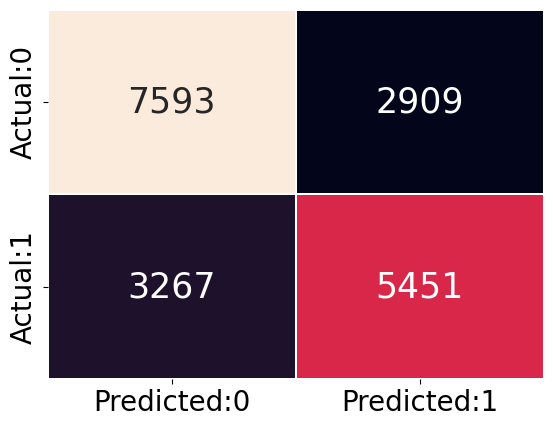

In [53]:
cm = confusion_matrix(ytest_xg, ypred_xg)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False,
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [54]:
print(classification_report(ytest_xg, ypred_xg))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71     10502
           1       0.65      0.63      0.64      8718

    accuracy                           0.68     19220
   macro avg       0.68      0.67      0.67     19220
weighted avg       0.68      0.68      0.68     19220



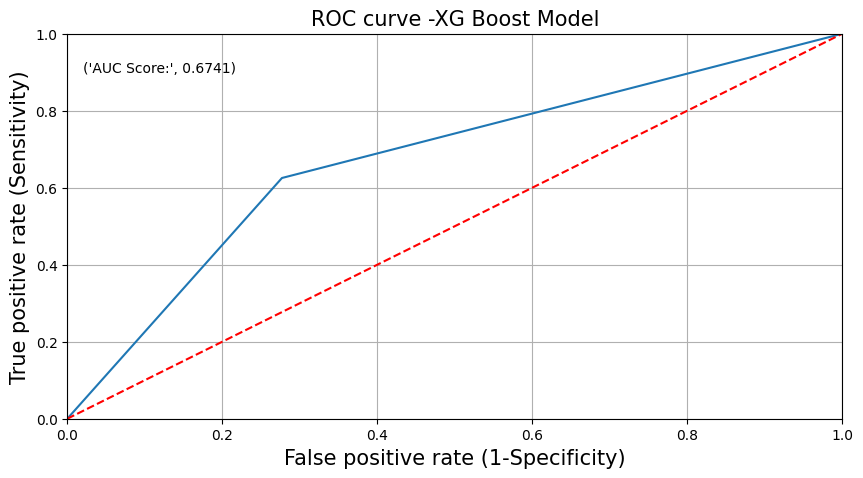

In [55]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(ytest_xg, ypred_proba_xg)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve -XG Boost Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(ytest_xg, ypred_proba_xg),4)))
plt.grid(True)

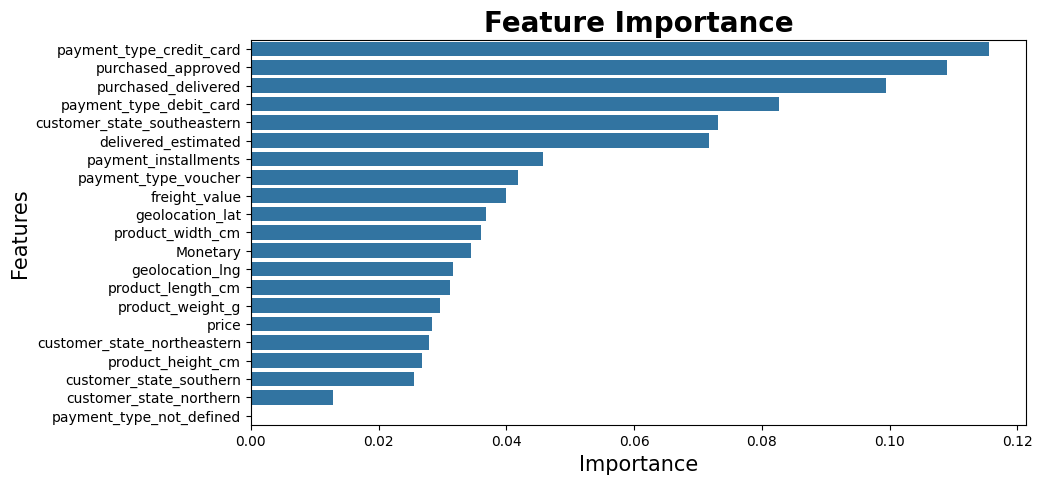

In [56]:
plt.figure(figsize=(10, 5))
important_features = pd.DataFrame({'Features': xtrain_xg.columns,
                                   'Importance': xbBoost.feature_importances_})
important_features = important_features.sort_values('Importance', ascending = False)
sns.barplot(x = 'Importance', y = 'Features', data = important_features)
plt.title('Feature Importance',color='black',fontsize=20,fontweight='bold')
plt.xlabel('Importance',color='black',fontsize=15)
plt.ylabel('Features',color='black',fontsize=15)
plt.show()

In [57]:
model_evaluation.loc['XGBoost'] = [accuracy_score(ytest_xg, ypred_xg), accuracy_score(ytrain_xg, ypred_xg_train),
                                          precision_score(ytest_xg, ypred_xg), precision_score(ytrain_xg, ypred_xg_train),
                                          recall_score(ytest_xg, ypred_xg), recall_score(ytrain_xg, ypred_xg_train),
                                          cohen_kappa_score(ytest_xg, ypred_xg), cohen_kappa_score(ytrain_xg, ypred_xg_train),
                                          f1_score(ytest_xg, ypred_xg), roc_auc_score(ytest_xg, ypred_proba_xg)]
model_evaluation

,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_kappa,train_kappa,f1_score,roc_auc_score
Logit_FullModel,0.580853,0.586867,0.557494,0.558840,0.400296,0.394567,0.136076,0.142913,0.465995,0.627612
RandomForest Classifier,0.660822,1.000000,0.649612,1.000000,0.547603,1.000000,0.306499,1.000000,0.594262,0.651206
XGBoost,0.678668,0.767704,0.652033,0.751801,0.625258,0.724590,0.349482,0.529465,0.638365,0.674132


### Catboost Classifier

In [148]:
xtrain_cat, xtest_cat, ytrain_cat, ytest_cat = train_test_split(X, df_target, test_size=0.2, random_state=500)

print('xtrain: ', xtrain_cat.shape)
print('ytrain: ', ytrain_cat.shape)
print('xtest: ', xtest_cat.shape)
print('ytest: ', ytest_cat.shape)

xtrain:  (76876, 21)
ytrain:  (76876,)
xtest:  (19220, 21)
ytest:  (19220,)


In [149]:
catBoost = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss')
catBoost.fit(X_train, y_train)

0:	learn: 0.6805581	total: 35.1ms	remaining: 35.1s
1:	learn: 0.6722831	total: 65.7ms	remaining: 32.8s
2:	learn: 0.6659397	total: 97ms	remaining: 32.2s
3:	learn: 0.6603797	total: 148ms	remaining: 36.9s
4:	learn: 0.6546311	total: 178ms	remaining: 35.3s
5:	learn: 0.6514485	total: 224ms	remaining: 37.1s
6:	learn: 0.6479353	total: 275ms	remaining: 39s
7:	learn: 0.6450671	total: 329ms	remaining: 40.9s
8:	learn: 0.6424134	total: 386ms	remaining: 42.5s
9:	learn: 0.6403133	total: 440ms	remaining: 43.6s
10:	learn: 0.6375730	total: 488ms	remaining: 43.9s
11:	learn: 0.6361583	total: 544ms	remaining: 44.8s
12:	learn: 0.6343846	total: 613ms	remaining: 46.5s
13:	learn: 0.6325996	total: 648ms	remaining: 45.7s
14:	learn: 0.6309012	total: 692ms	remaining: 45.5s
15:	learn: 0.6298569	total: 748ms	remaining: 46s
16:	learn: 0.6286913	total: 803ms	remaining: 46.4s
17:	learn: 0.6276930	total: 909ms	remaining: 49.6s
18:	learn: 0.6266274	total: 965ms	remaining: 49.8s
19:	learn: 0.6255829	total: 1.02s	remaining:

In [150]:
ypred_proba_cat = catBoost.predict_proba(xtest_cat)[:, 1]

In [151]:
ypred_cat = [0 if i < 0.5 else 1 for i in ypred_proba_cat]

In [152]:
ypred_proba_cat_train = catBoost.predict_proba(xtrain_cat)[:, 1]
ypred_cat_train = [0 if i < 0.5 else 1 for i in ypred_proba_cat_train]

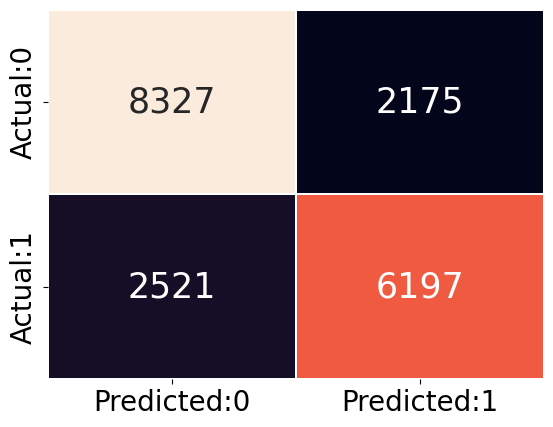

In [153]:
cm = confusion_matrix(ytest_cat, ypred_cat)
conf_matrix = pd.DataFrame(data=cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, linewidths=0.1, annot_kws={'size': 25})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [154]:
print(classification_report(ytest_cat, ypred_cat))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78     10502
           1       0.74      0.71      0.73      8718

    accuracy                           0.76     19220
   macro avg       0.75      0.75      0.75     19220
weighted avg       0.76      0.76      0.76     19220



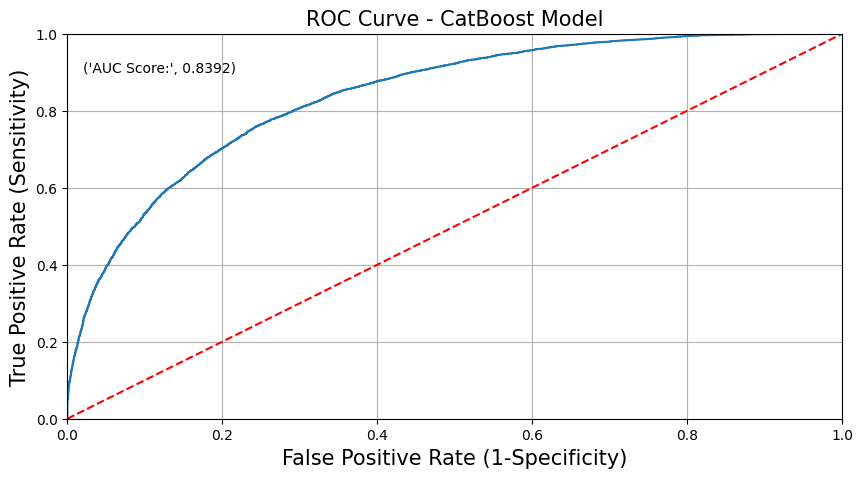

In [155]:
plt.figure(figsize=(10, 5))
fpr, tpr, thresholds = roc_curve(ytest_cat, ypred_proba_cat)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC Curve - CatBoost Model', fontsize=15)
plt.xlabel('False Positive Rate (1-Specificity)', fontsize=15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=15)
plt.text(x=0.02, y=0.9, s=('AUC Score:', round(roc_auc_score(ytest_cat, ypred_proba_cat), 4)))
plt.grid(True)

In [156]:
print("Number of features in xtrain_cat:", len(xtrain_cat.columns))
print("Number of features in CatBoost:", len(catBoost.feature_importances_))


Number of features in xtrain_cat: 21
Number of features in CatBoost: 22


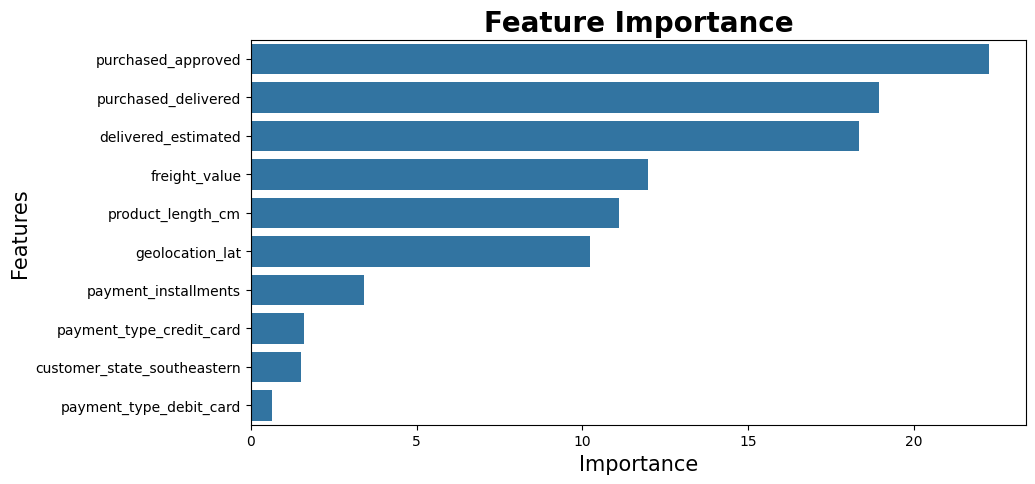

In [157]:
plt.figure(figsize=(10, 5))
important_features = important_features.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Features', data=important_features)
plt.title('Feature Importance', color='black', fontsize=20, fontweight='bold')
plt.xlabel('Importance', color='black', fontsize=15)
plt.ylabel('Features', color='black', fontsize=15)
plt.show()

In [158]:
print(model_evaluation.columns)


Index(['test_accuracy', 'train_accuracy', 'test_precision', 'train_precision',
       'test_recall', 'train_recall', 'test_kappa', 'train_kappa', 'f1_score',
       'roc_auc_score'],
      dtype='object')


In [159]:
model_evaluation.loc['CatBoost'] = [accuracy_score(ytest_cat, ypred_cat), accuracy_score(ytrain_cat, ypred_cat_train),
                                      precision_score(ytest_cat, ypred_cat), precision_score(ytrain_cat, ypred_cat_train),
                                      recall_score(ytest_cat, ypred_cat), recall_score(ytrain_cat, ypred_cat_train),
                                      cohen_kappa_score(ytest_cat, ypred_cat), cohen_kappa_score(ytrain_cat, ypred_cat_train),  # Kappa
                                      f1_score(ytest_cat, ypred_cat), roc_auc_score(ytest_cat, ypred_proba_cat)]
model_evaluation

,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_kappa,train_kappa,f1_score,roc_auc_score
Logit_FullModel,0.580853,0.586867,0.557494,0.558840,0.400296,0.394567,0.136076,0.142913,0.465995,0.627612
RandomForest Classifier,0.660822,1.000000,0.649612,1.000000,0.547603,1.000000,0.306499,1.000000,0.594262,0.651206
XGBoost,0.678668,0.767704,0.652033,0.751801,0.625258,0.724590,0.349482,0.529465,0.638365,0.674132
CatBoost,0.755671,0.757128,0.740205,0.740590,0.710828,0.710988,0.505429,0.507879,0.725219,0.839232
LightGBM,0.682882,0.731828,0.659530,0.712964,0.621932,0.679433,0.357140,0.456272,0.640179,0.757848


### Light GBM

In [70]:
xtrain_lgb, xtest_lgb, ytrain_lgb, ytest_lgb = train_test_split(X, df_target, test_size=0.2, random_state=500)

print('xtrain: ', xtrain_lgb.shape)
print('ytrain: ', ytrain_lgb.shape)
print('xtest: ', xtest_lgb.shape)
print('ytest: ', ytest_lgb.shape)

xtrain:  (76876, 21)
ytrain:  (76876,)
xtest:  (19220, 21)
ytest:  (19220,)


In [72]:
lgb_model = lgb.LGBMClassifier(
                                reg_lambda=1,   # L2 regularization (Ridge)
                                reg_alpha=0.5,  # L1 regularization (Lasso)
                                max_depth=6,    # Prevents overfitting
                                min_child_weight=3,  # Controls complexity
                                learning_rate=0.05,  # Stable learning
                                n_estimators=500  # More trees with smaller learning rate
                            )
lgb_model.fit(xtrain_lgb, ytrain_lgb)

[LightGBM] [Info] Number of positive: 34701, number of negative: 42175
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2828
[LightGBM] [Info] Number of data points in the train set: 76876, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451389 -> initscore=-0.195059
[LightGBM] [Info] Start training from score -0.195059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMClassifier(learning_rate=0.05, max_depth=6, min_child_weight=3,
               n_estimators=500, reg_alpha=0.5, reg_lambda=1)

In [73]:
ypred_proba_lgb = lgb_model.predict_proba(xtest_lgb)[:, 1]  # Probability for class 1
ypred_lgb = [0 if i < 0.5 else 1 for i in ypred_proba_lgb]

In [74]:
ypred_proba_lgb_train = lgb_model.predict_proba(xtrain_lgb)[:, 1]
ypred_lgb_train = [0 if i < 0.5 else 1 for i in ypred_proba_lgb_train]

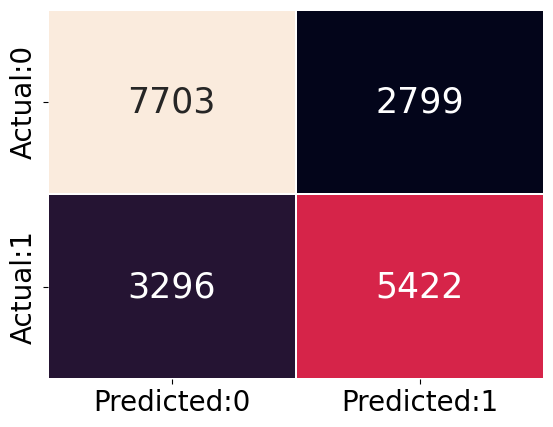

In [75]:
cm = confusion_matrix(ytest_lgb, ypred_lgb)
conf_matrix = pd.DataFrame(data=cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, linewidths=0.1, annot_kws={'size': 25})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


In [76]:
print(classification_report(ytest_lgb, ypred_lgb))

              precision    recall  f1-score   support

           0       0.70      0.73      0.72     10502
           1       0.66      0.62      0.64      8718

    accuracy                           0.68     19220
   macro avg       0.68      0.68      0.68     19220
weighted avg       0.68      0.68      0.68     19220



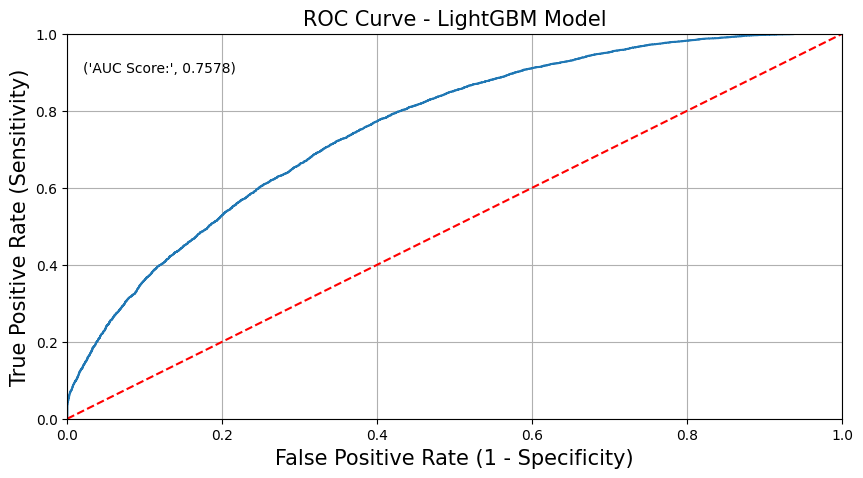

In [77]:
plt.figure(figsize=(10, 5))
fpr, tpr, thresholds = roc_curve(ytest_lgb, ypred_proba_lgb)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC Curve - LightGBM Model', fontsize=15)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=15)
plt.text(x=0.02, y=0.9, s=('AUC Score:', round(roc_auc_score(ytest_lgb, ypred_proba_lgb), 4)))
plt.grid(True)

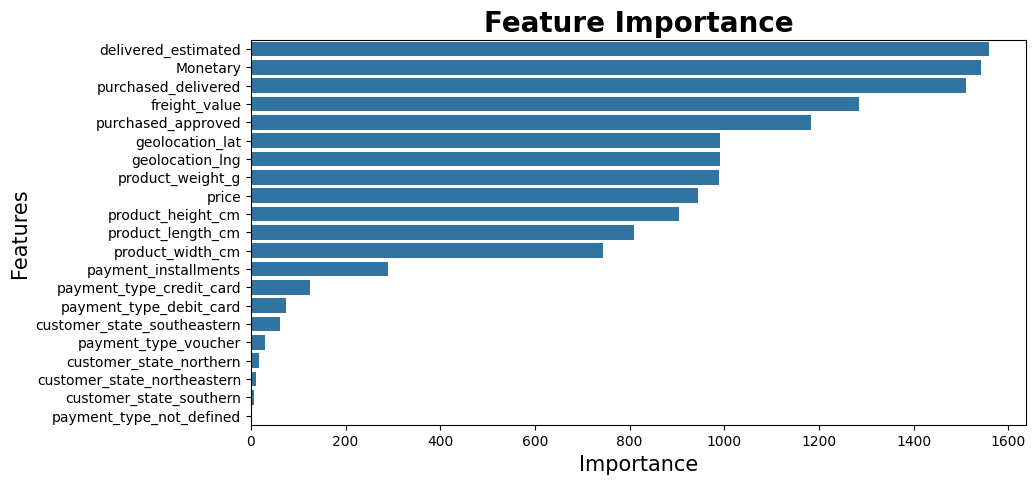

In [78]:
plt.figure(figsize=(10, 5))
important_features = pd.DataFrame({'Features': xtrain_lgb.columns, 'Importance': lgb_model.feature_importances_})
important_features = important_features.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Features', data=important_features)
plt.title('Feature Importance', color='black', fontsize=20, fontweight='bold')
plt.xlabel('Importance', color='black', fontsize=15)
plt.ylabel('Features', color='black', fontsize=15)
plt.show()

In [79]:
model_evaluation.loc['LightGBM'] = [
    accuracy_score(ytest_lgb, ypred_lgb), accuracy_score(ytrain_lgb, ypred_lgb_train),
    precision_score(ytest_lgb, ypred_lgb), precision_score(ytrain_lgb, ypred_lgb_train),
    recall_score(ytest_lgb, ypred_lgb), recall_score(ytrain_lgb, ypred_lgb_train),
    cohen_kappa_score(ytest_lgb, ypred_lgb), cohen_kappa_score(ytrain_lgb, ypred_lgb_train),
    f1_score(ytest_lgb, ypred_lgb), roc_auc_score(ytest_lgb, ypred_proba_lgb)
]

model_evaluation

,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_kappa,train_kappa,f1_score,roc_auc_score
Logit_FullModel,0.580853,0.586867,0.557494,0.558840,0.400296,0.394567,0.136076,0.142913,0.465995,0.627612
RandomForest Classifier,0.660822,1.000000,0.649612,1.000000,0.547603,1.000000,0.306499,1.000000,0.594262,0.651206
XGBoost,0.678668,0.767704,0.652033,0.751801,0.625258,0.724590,0.349482,0.529465,0.638365,0.674132
CatBoost,0.755671,0.757128,0.740205,0.740590,0.710828,0.710988,0.505429,0.507879,0.725219,0.839232
LightGBM,0.682882,0.731828,0.659530,0.712964,0.621932,0.679433,0.357140,0.456272,0.640179,0.757848


### *Model Insight*

- CatBoost outperforms other models in predicting churn, achieving the highest test accuracy (75.57%) and ROC-AUC score (83.92%). It balances precision (74.02%) and recall (71.08%), making it reliable for identifying churners while minimizing false positives.

- XGBoost and LightGBM also show competitive performance, with recall above 61%, ensuring they capture a significant portion of actual churners. However, their lower kappa scores indicate some inconsistency in predictions.

- Random Forest achieves perfect training accuracy but struggles with overfitting, as its test accuracy drops to 66.48%. Logistic Regression underperforms, with low recall (40.03%) and kappa (13.60%), making it less effective for churn detection.

**Conclusion**
- CatBoost is the best model due to its strong balance of accuracy, recall, and ROC-AUC. Logistic regression performs poorly, while Random Forest needs tuning to address overfitting.
- Given the importance of recall in churn prediction, CatBoost is the best choice, as it effectively distinguishes churners from non-churners while maintaining high overall performance.

## Model Recursive Feature Elimination

Recursive Feature Elimination (RFE) is a feature selection technique used to improve model performance by selecting the most relevant features. It works by iteratively training a model, ranking features based on importance, and removing the least important ones until the desired number of features remains.

In [80]:
model_evaluation.sort_values(by='test_recall',ascending=False)

,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_kappa,train_kappa,f1_score,roc_auc_score
CatBoost,0.755671,0.757128,0.740205,0.740590,0.710828,0.710988,0.505429,0.507879,0.725219,0.839232
XGBoost,0.678668,0.767704,0.652033,0.751801,0.625258,0.724590,0.349482,0.529465,0.638365,0.674132
LightGBM,0.682882,0.731828,0.659530,0.712964,0.621932,0.679433,0.357140,0.456272,0.640179,0.757848
RandomForest Classifier,0.660822,1.000000,0.649612,1.000000,0.547603,1.000000,0.306499,1.000000,0.594262,0.651206
Logit_FullModel,0.580853,0.586867,0.557494,0.558840,0.400296,0.394567,0.136076,0.142913,0.465995,0.627612


### XGBoost - RFE

In [81]:
X_train_rfe = X_train.iloc[:,1:]
X_test_rfe = X_test.iloc[:,1:]
xg =  XGBClassifier()
xgb_model = RFE(estimator = xg, n_features_to_select = 10)
rfe_model = xgb_model.fit(X_train_rfe, y_train)
feat_index = pd.Series(data = rfe_model.ranking_, index = X_train_rfe.columns)
signi_feat_rfe_xg = feat_index[feat_index==1].index
print(signi_feat_rfe_xg)

Index(['purchased_approved', 'delivered_estimated', 'purchased_delivered',
       'freight_value', 'product_length_cm', 'geolocation_lat',
       'payment_installments', 'customer_state_southeastern',
       'payment_type_credit_card', 'payment_type_debit_card'],
      dtype='object')


In [82]:
xtrain_xg, xtest_xg, ytrain_xg, ytest_xg = train_test_split(X[signi_feat_rfe_xg], df_target, random_state = 1000, test_size = 0.2)
print('xtrain: ', xtrain_xg.shape)
print('ytrain: ', ytrain_xg.shape)
print('xtest: ', xtest_xg.shape)
print('ytest: ', ytest_xg.shape)

xtrain:  (76876, 10)
ytrain:  (76876,)
xtest:  (19220, 10)
ytest:  (19220,)


In [83]:
gBoost = XGBClassifier()
xbBoost = xgBoost.fit(xtrain_xg, ytrain_xg)

In [84]:
ypred_proba_xg = xgBoost.predict(xtest_xg)
ypred_xg = [0 if i < 0.5 else 1 for i in ypred_proba_xg]
ypred_xg[:10]

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1]

In [85]:
ypred_proba_xg_train = xgBoost.predict(xtrain_xg)
ypred_xg_train = [0 if i < 0.5 else 1 for i in ypred_proba_xg_train]

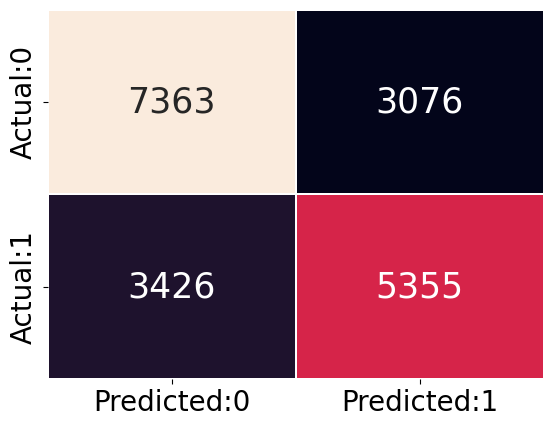

In [86]:
cm = confusion_matrix(ytest_xg, ypred_xg)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False,
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [87]:
print(classification_report(ytest_xg, ypred_xg))

              precision    recall  f1-score   support

           0       0.68      0.71      0.69     10439
           1       0.64      0.61      0.62      8781

    accuracy                           0.66     19220
   macro avg       0.66      0.66      0.66     19220
weighted avg       0.66      0.66      0.66     19220



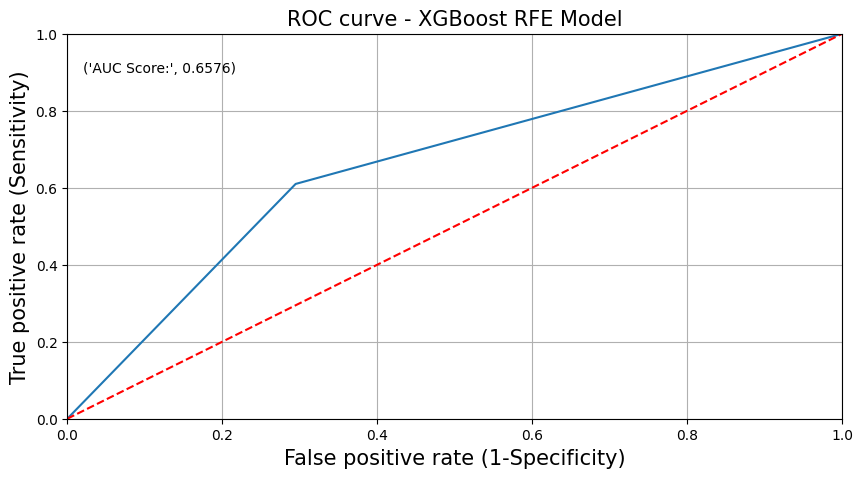

In [88]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(ytest_xg, ypred_proba_xg)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve - XGBoost RFE Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(ytest_xg, ypred_proba_xg),4)))
plt.grid(True)

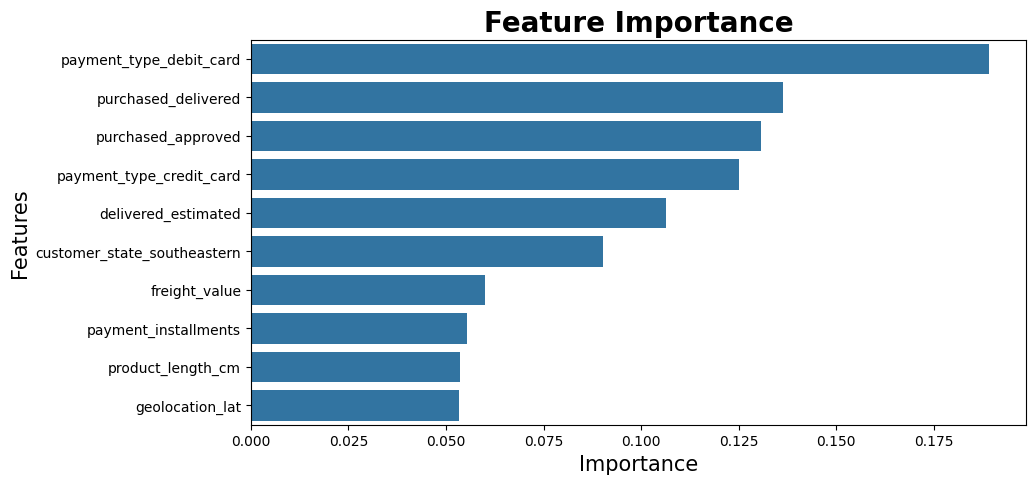

In [89]:
plt.figure(figsize=(10, 5))
important_features = pd.DataFrame({'Features': xtrain_xg.columns,
                                   'Importance': xbBoost.feature_importances_})
important_features = important_features.sort_values('Importance', ascending = False)
sns.barplot(x = 'Importance', y = 'Features', data = important_features)
plt.title('Feature Importance',color='black',fontsize=20,fontweight='bold')
plt.xlabel('Importance',color='black',fontsize=15)
plt.ylabel('Features',color='black',fontsize=15)
plt.show()

In [90]:
cols = ['test_accuracy', 'train_accuracy', 'test_precision', 'train_precision','test_recall','train_recall', 'test_kappa', 'train_kappa', 'f1_score','roc_auc_score']
RFE_model_evaluation = pd.DataFrame(columns=cols)
RFE_model_evaluation.loc['XGBoost RFE'] = [accuracy_score(ytest_xg, ypred_xg), accuracy_score(ytrain_xg, ypred_xg_train),
                                          precision_score(ytest_xg, ypred_xg), precision_score(ytrain_xg, ypred_xg_train),
                                          recall_score(ytest_xg, ypred_xg), recall_score(ytrain_xg, ypred_xg_train),
                                          cohen_kappa_score(ytest_xg, ypred_xg), cohen_kappa_score(ytrain_xg, ypred_xg_train),
                                          f1_score(ytest_xg, ypred_xg), roc_auc_score(ytest_xg, ypred_proba_xg)]
RFE_model_evaluation

,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_kappa,train_kappa,f1_score,roc_auc_score
XGBoost RFE,0.661707,0.731971,0.635156,0.708533,0.609839,0.688261,0.316176,0.457254,0.62224,0.657588


### LightGBM - RFE

In [91]:
# Prepare data
X_train_rfe = X_train.iloc[:, 1:]
X_test_rfe = X_test.iloc[:, 1:]

# Initialize LightGBM model
lgbm = lgb.LGBMClassifier()

# Perform RFE to select top 10 features
lgbm_model = RFE(estimator=lgbm, n_features_to_select=10)
rfe_model = lgbm_model.fit(X_train_rfe, y_train)

# Get the selected features
feat_index = pd.Series(data=rfe_model.ranking_, index=X_train_rfe.columns)
signi_feat_rfe_lgbm = feat_index[feat_index == 1].index
print(signi_feat_rfe_lgbm)

[LightGBM] [Info] Number of positive: 34638, number of negative: 42238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2822
[LightGBM] [Info] Number of data points in the train set: 76876, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450570 -> initscore=-0.198369
[LightGBM] [Info] Start training from score -0.198369
[LightGBM] [Info] Number of positive: 34638, number of negative: 42238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2819
[LightGBM] [Info] Number of data points in the train set: 76876, number of used features: 19
[LightGBM] [Info] 

In [92]:
# Train-Test split with selected features
xtrain_lgbm, xtest_lgbm, ytrain_lgbm, ytest_lgbm = train_test_split(X[signi_feat_rfe_lgbm], df_target, random_state=1000, test_size=0.2)
print('xtrain:', xtrain_lgbm.shape)
print('ytrain:', ytrain_lgbm.shape)
print('xtest:', xtest_lgbm.shape)
print('ytest:', ytest_lgbm.shape)

xtrain: (76876, 10)
ytrain: (76876,)
xtest: (19220, 10)
ytest: (19220,)


In [93]:
# Train the LightGBM model
lgbm_model = lgb.LGBMClassifier()
lgbm_model.fit(xtrain_lgbm, ytrain_lgbm)

[LightGBM] [Info] Number of positive: 34638, number of negative: 42238
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 76876, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450570 -> initscore=-0.198369
[LightGBM] [Info] Start training from score -0.198369


LGBMClassifier()

In [94]:
# Predictions
ypred_proba_lgbm = lgbm_model.predict_proba(xtest_lgbm)[:, 1]
ypred_lgbm = [0 if i < 0.5 else 1 for i in ypred_proba_lgbm]

In [95]:
ypred_proba_lgbm_train = lgbm_model.predict_proba(xtrain_lgbm)[:, 1]
ypred_lgbm_train = [0 if i < 0.5 else 1 for i in ypred_proba_lgbm_train]

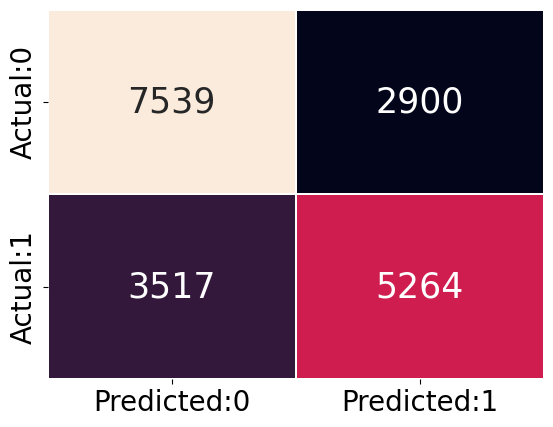

In [96]:
# Confusion Matrix
cm = confusion_matrix(ytest_lgbm, ypred_lgbm)
conf_matrix = pd.DataFrame(data=cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, linewidths=0.1, annot_kws={'size': 25})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [97]:
# Classification Report
print(classification_report(ytest_lgbm, ypred_lgbm))

              precision    recall  f1-score   support

           0       0.68      0.72      0.70     10439
           1       0.64      0.60      0.62      8781

    accuracy                           0.67     19220
   macro avg       0.66      0.66      0.66     19220
weighted avg       0.66      0.67      0.66     19220



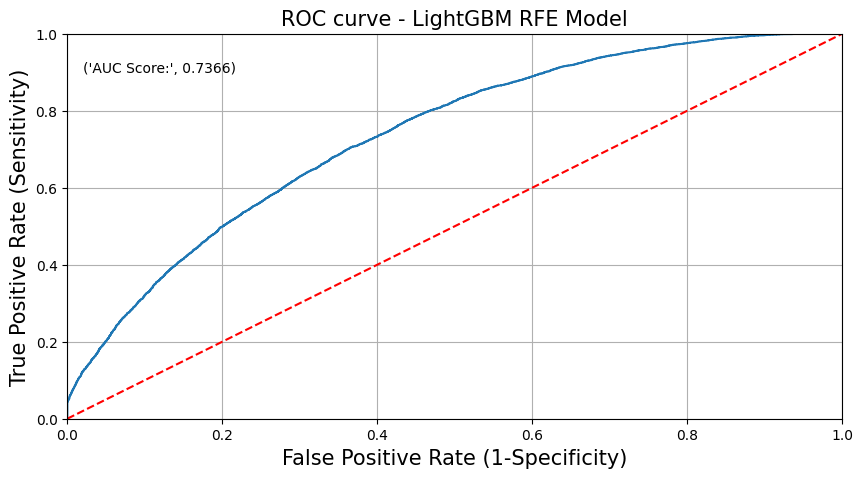

In [98]:
# ROC Curve
plt.figure(figsize=(10, 5))
fpr, tpr, thresholds = roc_curve(ytest_lgbm, ypred_proba_lgbm)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC curve - LightGBM RFE Model', fontsize=15)
plt.xlabel('False Positive Rate (1-Specificity)', fontsize=15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=15)
plt.text(x=0.02, y=0.9, s=('AUC Score:', round(roc_auc_score(ytest_lgbm, ypred_proba_lgbm), 4)))
plt.grid(True)

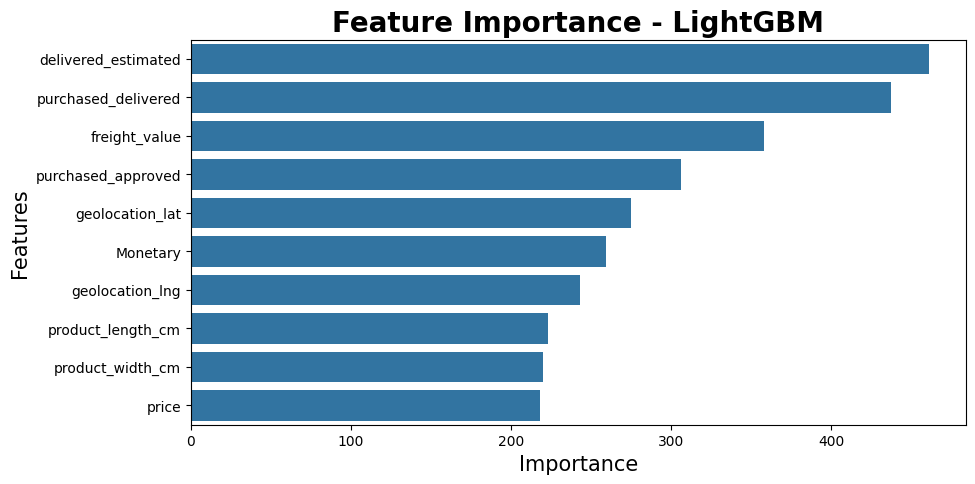

In [99]:
# Feature Importance
plt.figure(figsize=(10, 5))
important_features = pd.DataFrame({'Features': xtrain_lgbm.columns, 'Importance': lgbm_model.feature_importances_})
important_features = important_features.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Features', data=important_features)
plt.title('Feature Importance - LightGBM', color='black', fontsize=20, fontweight='bold')
plt.xlabel('Importance', color='black', fontsize=15)
plt.ylabel('Features', color='black', fontsize=15)
plt.show()

In [100]:
# Model Evaluation
RFE_model_evaluation.loc['LightGBM RFE'] = [
    accuracy_score(ytest_lgbm, ypred_lgbm), accuracy_score(ytrain_lgbm, ypred_lgbm_train),
    precision_score(ytest_lgbm, ypred_lgbm), precision_score(ytrain_lgbm, ypred_lgbm_train),
    recall_score(ytest_lgbm, ypred_lgbm), recall_score(ytrain_lgbm, ypred_lgbm_train),
    cohen_kappa_score(ytest_lgbm, ypred_lgbm), cohen_kappa_score(ytrain_lgbm, ypred_lgbm_train),
    f1_score(ytest_lgbm, ypred_lgbm), roc_auc_score(ytest_lgbm, ypred_proba_lgbm)
]
RFE_model_evaluation

,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_kappa,train_kappa,f1_score,roc_auc_score
XGBoost RFE,0.661707,0.731971,0.635156,0.708533,0.609839,0.688261,0.316176,0.457254,0.622240,0.657588
LightGBM RFE,0.666129,0.693741,0.644782,0.672535,0.599476,0.624228,0.323477,0.377412,0.621304,0.736615


### Catboost - RFE

In [106]:
# Prepare data
X_train_rfe = X_train.iloc[:, 1:]
X_test_rfe = X_test.iloc[:, 1:]

# Initialize CatBoost model
catboost = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss')

# Perform RFE to select top 10 features
catboost_model = RFE(estimator=catboost, n_features_to_select=10)
rfe_model = catboost_model.fit(X_train_rfe, y_train)

# Get the selected features
feat_index = pd.Series(data=rfe_model.ranking_, index=X_train_rfe.columns)
signi_feat_rfe_catboost = feat_index[feat_index == 1].index
print(signi_feat_rfe_catboost)

Streaming output truncated to the last 5000 lines.
4:	learn: 0.6555017	total: 98.3ms	remaining: 19.6s
5:	learn: 0.6509490	total: 120ms	remaining: 19.8s
6:	learn: 0.6475593	total: 140ms	remaining: 19.9s
7:	learn: 0.6451184	total: 162ms	remaining: 20.1s
8:	learn: 0.6431699	total: 182ms	remaining: 20s
9:	learn: 0.6407483	total: 201ms	remaining: 19.9s
10:	learn: 0.6390342	total: 227ms	remaining: 20.4s
11:	learn: 0.6372134	total: 252ms	remaining: 20.7s
12:	learn: 0.6350228	total: 272ms	remaining: 20.6s
13:	learn: 0.6335335	total: 293ms	remaining: 20.6s
14:	learn: 0.6326492	total: 312ms	remaining: 20.5s
15:	learn: 0.6312340	total: 333ms	remaining: 20.5s
16:	learn: 0.6292364	total: 352ms	remaining: 20.3s
17:	learn: 0.6277762	total: 373ms	remaining: 20.3s
18:	learn: 0.6270509	total: 393ms	remaining: 20.3s
19:	learn: 0.6259210	total: 414ms	remaining: 20.3s
20:	learn: 0.6253485	total: 444ms	remaining: 20.7s
21:	learn: 0.6242265	total: 464ms	remaining: 20.6s
22:	learn: 0.6233564	total: 484ms	rema

In [107]:
# Train-Test split with selected features
xtrain_catboost, xtest_catboost, ytrain_catboost, ytest_catboost = train_test_split(
    X[signi_feat_rfe_catboost], df_target, random_state=500, test_size=0.2
)
print('xtrain:', xtrain_catboost.shape)
print('ytrain:', ytrain_catboost.shape)
print('xtest:', xtest_catboost.shape)
print('ytest:', ytest_catboost.shape)

xtrain: (76876, 10)
ytrain: (76876,)
xtest: (19220, 10)
ytest: (19220,)


In [108]:
# Train the CatBoost model
catboost_model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss')
catboost_model.fit(xtrain_catboost, ytrain_catboost)


0:	learn: 0.6812643	total: 26.5ms	remaining: 26.5s
1:	learn: 0.6728877	total: 47ms	remaining: 23.4s
2:	learn: 0.6669991	total: 67.2ms	remaining: 22.3s
3:	learn: 0.6620727	total: 88.6ms	remaining: 22.1s
4:	learn: 0.6572838	total: 126ms	remaining: 25.1s
5:	learn: 0.6526580	total: 145ms	remaining: 24.1s
6:	learn: 0.6493179	total: 163ms	remaining: 23.1s
7:	learn: 0.6460338	total: 181ms	remaining: 22.4s
8:	learn: 0.6426273	total: 199ms	remaining: 21.9s
9:	learn: 0.6409337	total: 218ms	remaining: 21.6s
10:	learn: 0.6390662	total: 248ms	remaining: 22.3s
11:	learn: 0.6368783	total: 267ms	remaining: 21.9s
12:	learn: 0.6355466	total: 288ms	remaining: 21.9s
13:	learn: 0.6342297	total: 307ms	remaining: 21.6s
14:	learn: 0.6328839	total: 328ms	remaining: 21.5s
15:	learn: 0.6319150	total: 345ms	remaining: 21.2s
16:	learn: 0.6303871	total: 365ms	remaining: 21.1s
17:	learn: 0.6294022	total: 383ms	remaining: 20.9s
18:	learn: 0.6283855	total: 403ms	remaining: 20.8s
19:	learn: 0.6273479	total: 422ms	remai

In [109]:
# Predictions
test_proba = catboost_model.predict_proba(xtest_catboost)[:, 1]
test_preds = [0 if i < 0.5 else 1 for i in test_proba]
train_proba = catboost_model.predict_proba(xtrain_catboost)[:, 1]
train_preds = [0 if i < 0.5 else 1 for i in train_proba]

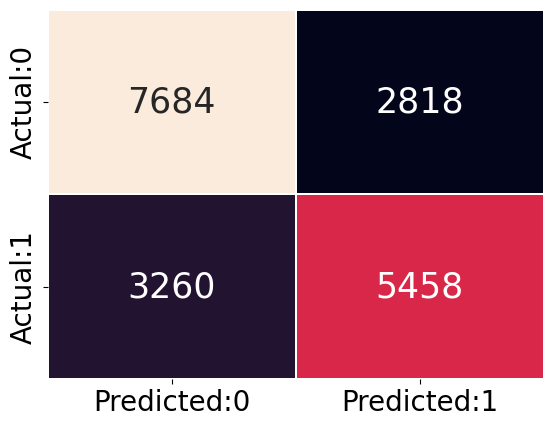

In [110]:
# Confusion Matrix
cm = confusion_matrix(ytest_catboost, test_preds)
conf_matrix = pd.DataFrame(data=cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, linewidths=0.1, annot_kws={'size': 25})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


In [111]:
# Classification Report
print(classification_report(ytest_catboost, test_preds))

              precision    recall  f1-score   support

           0       0.70      0.73      0.72     10502
           1       0.66      0.63      0.64      8718

    accuracy                           0.68     19220
   macro avg       0.68      0.68      0.68     19220
weighted avg       0.68      0.68      0.68     19220



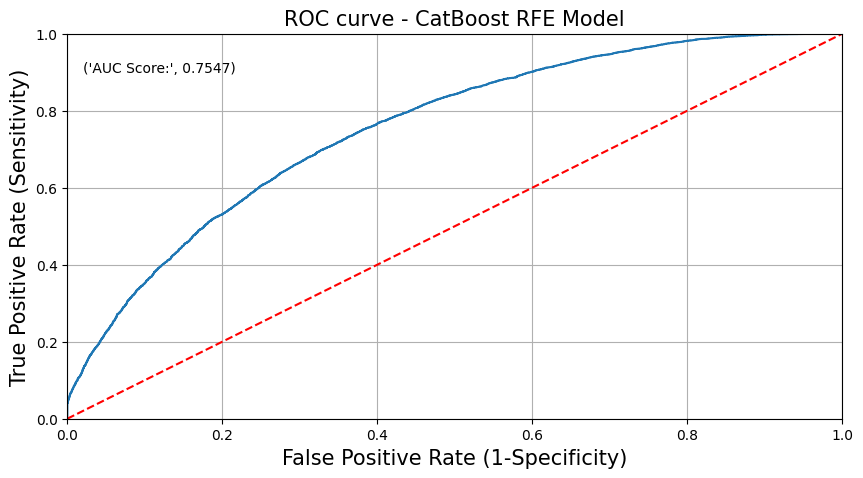

In [112]:
# ROC Curve
plt.figure(figsize=(10, 5))
fpr, tpr, thresholds = roc_curve(ytest_catboost, test_proba)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC curve - CatBoost RFE Model', fontsize=15)
plt.xlabel('False Positive Rate (1-Specificity)', fontsize=15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=15)
plt.text(x=0.02, y=0.9, s=('AUC Score:', round(roc_auc_score(ytest_catboost, test_proba), 4)))
plt.grid(True)

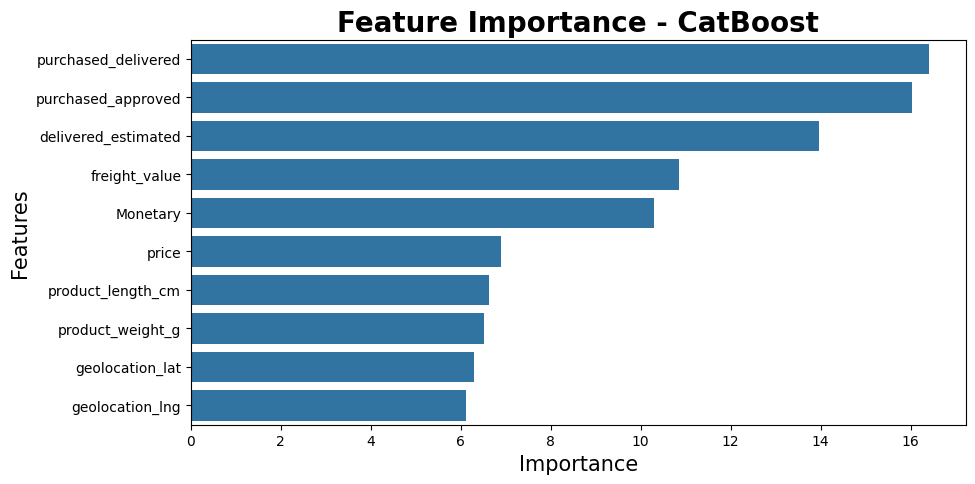

In [113]:
# Feature Importance
plt.figure(figsize=(10, 5))
important_features = pd.DataFrame({'Features': xtrain_catboost.columns, 'Importance': catboost_model.feature_importances_})
important_features = important_features.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Features', data=important_features)
plt.title('Feature Importance - CatBoost', color='black', fontsize=20, fontweight='bold')
plt.xlabel('Importance', color='black', fontsize=15)
plt.ylabel('Features', color='black', fontsize=15)
plt.show()

In [114]:
RFE_model_evaluation.loc['CatBoost RFE'] = [
    accuracy_score(ytest_catboost, test_preds), accuracy_score(ytrain_catboost, train_preds),
    precision_score(ytest_catboost, test_preds), precision_score(ytrain_catboost, train_preds),
    recall_score(ytest_catboost, test_preds), recall_score(ytrain_catboost, train_preds),
    cohen_kappa_score(ytest_catboost, test_preds), cohen_kappa_score(ytrain_catboost, train_preds),
    f1_score(ytest_catboost, test_preds), roc_auc_score(ytest_catboost, test_proba)
]
RFE_model_evaluation

,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_kappa,train_kappa,f1_score,roc_auc_score
XGBoost RFE,0.661707,0.731971,0.635156,0.708533,0.609839,0.688261,0.316176,0.457254,0.622240,0.657588
LightGBM RFE,0.666129,0.693741,0.644782,0.672535,0.599476,0.624228,0.323477,0.377412,0.621304,0.736615
CatBoost RFE,0.683767,0.759821,0.659497,0.745057,0.626061,0.711305,0.359278,0.513104,0.642344,0.754670


### *Insight*

- Test accuracy slightly drops for all models, but overfitting is reduced (smaller gap between train and test scores).
- CatBoost RFE improves generalization, reducing overfitting and maintaining good test accuracy (0.6838).
- XGBoost and LightGBM also show improved kappa scores, meaning their predictions are more reliable.
- ROC AUC remains high, especially for CatBoost RFE (0.7547), meaning the model still separates classes well.

RFE reduces overfitting and improves model stability, but there's a slight trade-off in accuracy.

## Hyperparameter Tuning

### XGBoost - Tuning

In [115]:
xtrain_xg, xtest_xg, ytrain_xg, ytest_xg = train_test_split(X[signi_feat_rfe_xg], df_target, test_size = 0.2, random_state = 1000)
print('xtrain: ', xtrain_xg.shape)
print('ytrain: ', ytrain_xg.shape)
print('xtest: ', xtest_xg.shape)
print('ytest: ', ytest_xg.shape)

xtrain:  (76876, 10)
ytrain:  (76876,)
xtest:  (19220, 10)
ytest:  (19220,)


In [116]:
xgb = XGBClassifier()
parameters = [{'n_estimators': [30, 40, 50, 70, 90],
               'max_depth': range(2, 7),
                'learning_rate': [0.1, 0.2, 0.4, 0.5]}]
gcv_xgb = GridSearchCV(estimator = xgb, param_grid = parameters, cv = 5)
gcv_xgb.fit(xtrain_xg, ytrain_xg)
gcv_xgb.best_params_

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 90}

In [117]:
xgBoost = XGBClassifier(learning_rate = 0.5,max_depth = 6,n_estimators = 90)
xgBoost.fit(xtrain_xg, ytrain_xg)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=90, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [118]:
ypred_proba_xg = xgBoost.predict(xtest_xg)
ypred_xg = [0 if i < 0.5 else 1 for i in ypred_proba_xg]
ypred_xg[:10]

[1, 1, 1, 1, 1, 0, 0, 1, 1, 1]

In [119]:
ypred_proba_xg_train = xgBoost.predict(xtrain_xg)
ypred_xg_train = [0 if i < 0.5 else 1 for i in ypred_proba_xg_train]

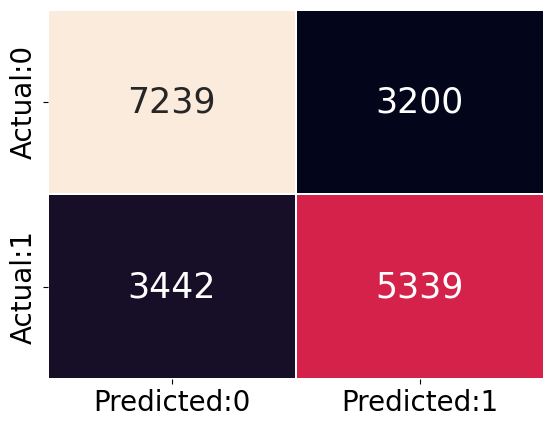

In [120]:
cm = confusion_matrix(ytest_xg, ypred_xg)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False,
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [121]:
print(classification_report(ytest_xg, ypred_xg))

              precision    recall  f1-score   support

           0       0.68      0.69      0.69     10439
           1       0.63      0.61      0.62      8781

    accuracy                           0.65     19220
   macro avg       0.65      0.65      0.65     19220
weighted avg       0.65      0.65      0.65     19220



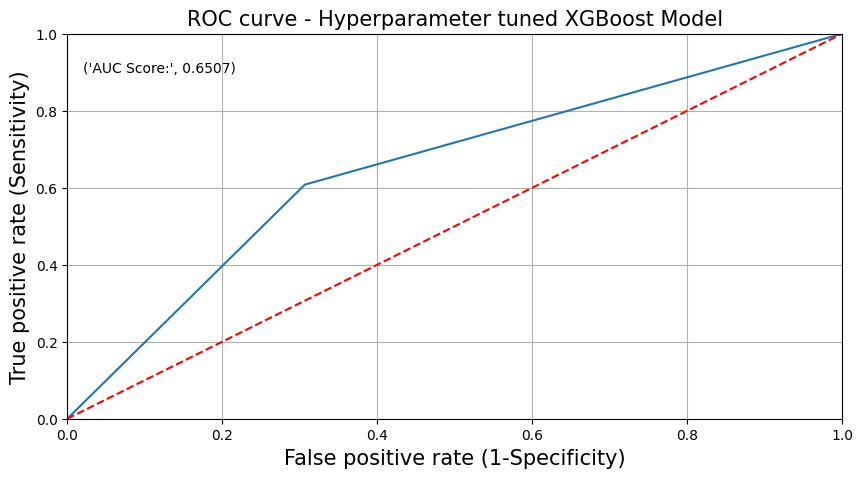

In [122]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(ytest_xg, ypred_proba_xg)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve - Hyperparameter tuned XGBoost Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(ytest_xg, ypred_proba_xg),4)))
plt.grid(True)

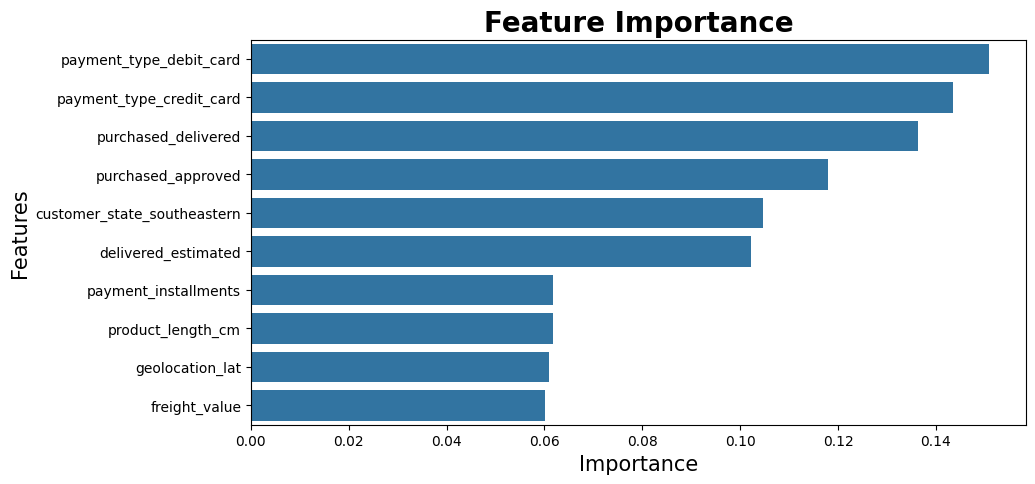

In [123]:
plt.figure(figsize=(10, 5))
important_features = pd.DataFrame({'Features': xtrain_xg.columns,
                                   'Importance': xgBoost.feature_importances_})
important_features = important_features.sort_values('Importance', ascending = False)
sns.barplot(x = 'Importance', y = 'Features', data = important_features)
plt.title('Feature Importance',color='black',fontsize=20,fontweight='bold')
plt.xlabel('Importance',color='black',fontsize=15)
plt.ylabel('Features',color='black',fontsize=15)
plt.show()

In [124]:
cols = ['test_accuracy', 'train_accuracy', 'test_precision', 'train_precision','test_recall','train_recall', 'test_kappa', 'train_kappa', 'f1_score','roc_auc_score']
model_evaluation_tuned = pd.DataFrame(columns=cols)
model_evaluation_tuned.loc['Tuned XGBoost Classifier'] = [accuracy_score(ytest_xg, ypred_xg), accuracy_score(ytrain_xg, ypred_xg_train),
                                          precision_score(ytest_xg, ypred_xg), precision_score(ytrain_xg, ypred_xg_train),
                                          recall_score(ytest_xg, ypred_xg), recall_score(ytrain_xg, ypred_xg_train),
                                          cohen_kappa_score(ytest_xg, ypred_xg), cohen_kappa_score(ytrain_xg, ypred_xg_train),
                                          f1_score(ytest_xg, ypred_xg), roc_auc_score(ytest_xg, ypred_proba_xg)]
model_evaluation_tuned

,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_kappa,train_kappa,f1_score,roc_auc_score
Tuned XGBoost Classifier,0.654422,0.749662,0.625249,0.728011,0.608017,0.709452,0.302136,0.49322,0.616513,0.650737


### LightGBM - Tuning

In [125]:
import lightgbm as lgb


In [126]:
# Splitting data
xtrain_lgb, xtest_lgb, ytrain_lgb, ytest_lgb = train_test_split(
    X[signi_feat_rfe_xg], df_target, test_size=0.2, random_state=1000
)
print('xtrain: ', xtrain_lgb.shape)
print('ytrain: ', ytrain_lgb.shape)
print('xtest: ', xtest_lgb.shape)
print('ytest: ', ytest_lgb.shape)

xtrain:  (76876, 10)
ytrain:  (76876,)
xtest:  (19220, 10)
ytest:  (19220,)


In [127]:
# Hyperparameter tuning
lgb = lgb.LGBMClassifier()
parameters = {
    'n_estimators': [30, 40, 50, 70, 90],
    'max_depth': range(2, 7),
    'learning_rate': [0.1, 0.2, 0.4, 0.5]
}
gcv_lgb = GridSearchCV(estimator=lgb, param_grid=parameters, cv=5)
gcv_lgb.fit(xtrain_lgb, ytrain_lgb)
best_params_lgb = gcv_lgb.best_params_

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [128]:
import lightgbm as lgb

In [129]:
lgbm_model = lgb.LGBMClassifier(
    learning_rate=best_params_lgb['learning_rate'],
    max_depth=best_params_lgb['max_depth'],
    n_estimators=best_params_lgb['n_estimators']
)
lgbm_model.fit(xtrain_lgb, ytrain_lgb)


[LightGBM] [Info] Number of positive: 34638, number of negative: 42238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 76876, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.450570 -> initscore=-0.198369
[LightGBM] [Info] Start training from score -0.198369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMClassifier(learning_rate=0.2, max_depth=5, n_estimators=90)

In [130]:
# Predictions
ypred_proba_lgb = lgbm_model.predict(xtest_lgb)
ypred_lgb = [0 if i < 0.5 else 1 for i in ypred_proba_lgb]

In [131]:
ypred_proba_lgb_train = lgbm_model.predict(xtrain_lgb)
ypred_lgb_train = [0 if i < 0.5 else 1 for i in ypred_proba_lgb_train]

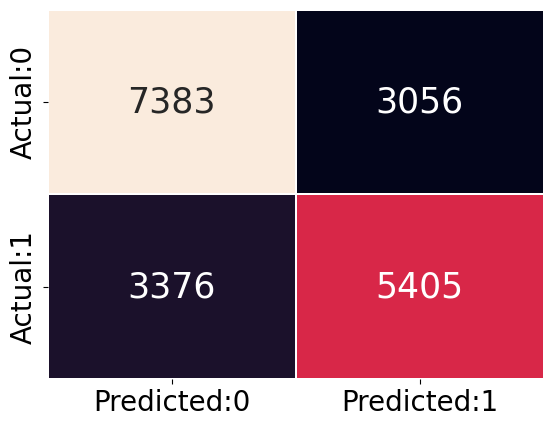

In [132]:
# Confusion matrix
cm = confusion_matrix(ytest_lgb, ypred_lgb)
conf_matrix = pd.DataFrame(
    data=cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1']
)
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False,
            linewidths=0.1, annot_kws={'size': 25})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [133]:
# Classification report
print(classification_report(ytest_lgb, ypred_lgb))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70     10439
           1       0.64      0.62      0.63      8781

    accuracy                           0.67     19220
   macro avg       0.66      0.66      0.66     19220
weighted avg       0.66      0.67      0.66     19220



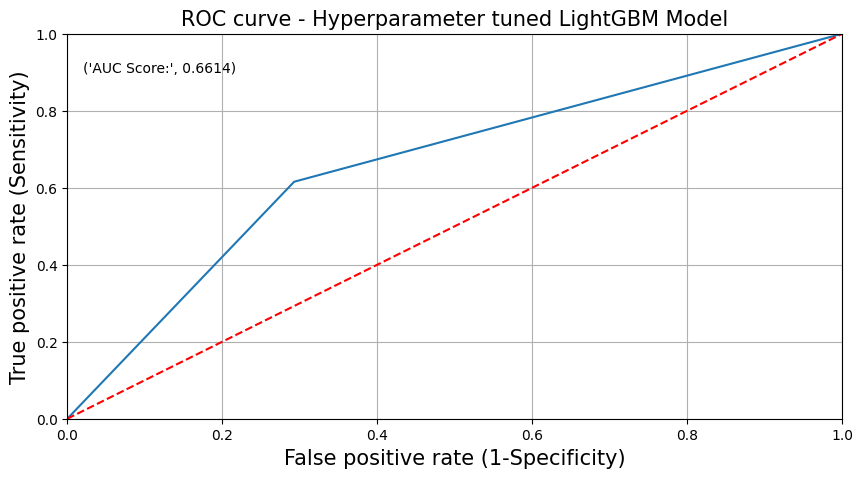

In [134]:
# ROC Curve
plt.figure(figsize=(10, 5))
fpr, tpr, _ = roc_curve(ytest_lgb, ypred_proba_lgb)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC curve - Hyperparameter tuned LightGBM Model', fontsize=15)
plt.xlabel('False positive rate (1-Specificity)', fontsize=15)
plt.ylabel('True positive rate (Sensitivity)', fontsize=15)
plt.text(
    x=0.02, y=0.9,
    s=('AUC Score:', round(roc_auc_score(ytest_lgb, ypred_proba_lgb), 4))
)
plt.grid(True)
plt.show()


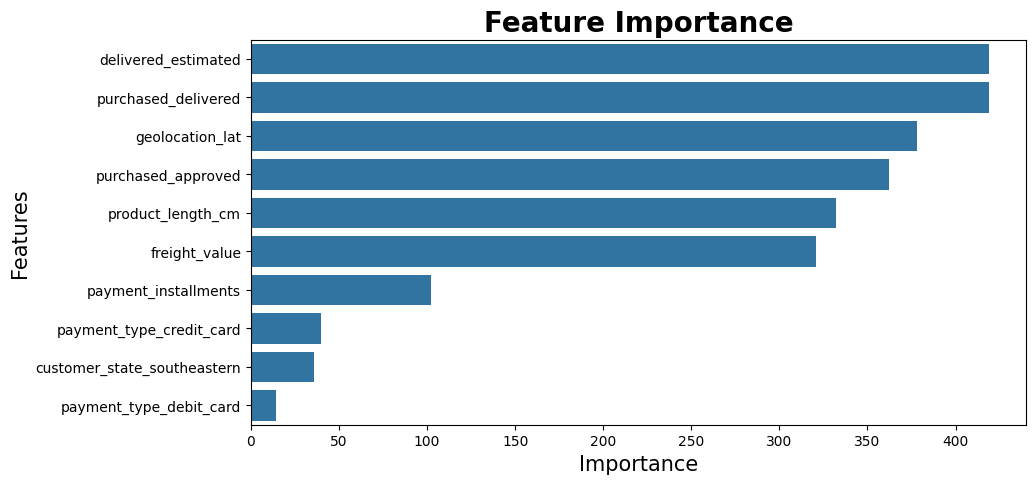

In [135]:
# Feature importance
plt.figure(figsize=(10, 5))
important_features = pd.DataFrame(
    {'Features': xtrain_lgb.columns, 'Importance': lgbm_model.feature_importances_}
)
important_features = important_features.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Features', data=important_features)
plt.title('Feature Importance', color='black', fontsize=20, fontweight='bold')
plt.xlabel('Importance', color='black', fontsize=15)
plt.ylabel('Features', color='black', fontsize=15)
plt.show()

In [136]:
model_evaluation_tuned.loc['Tuned LightGBM Classifier'] = [
    accuracy_score(ytest_lgb, ypred_lgb), accuracy_score(ytrain_lgb, ypred_lgb_train),
    precision_score(ytest_lgb, ypred_lgb), precision_score(ytrain_lgb, ypred_lgb_train),
    recall_score(ytest_lgb, ypred_lgb), recall_score(ytrain_lgb, ypred_lgb_train),
    cohen_kappa_score(ytest_lgb, ypred_lgb), cohen_kappa_score(ytrain_lgb, ypred_lgb_train),
    f1_score(ytest_lgb, ypred_lgb), roc_auc_score(ytest_lgb, ypred_proba_lgb)
]
model_evaluation_tuned

,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_kappa,train_kappa,f1_score,roc_auc_score
Tuned XGBoost Classifier,0.654422,0.749662,0.625249,0.728011,0.608017,0.709452,0.302136,0.493220,0.616513,0.650737
Tuned LightGBM Classifier,0.665349,0.689643,0.638813,0.662173,0.615534,0.635314,0.323722,0.370864,0.626957,0.661393


### Catboost - Tuning

In [161]:
# Splitting the dataset
xtrain_cat, xtest_cat, ytrain_cat, ytest_cat = train_test_split(
    X[signi_feat_rfe_xg], df_target, test_size=0.2, random_state=500
)

print('xtrain: ', xtrain_cat.shape)
print('ytrain: ', ytrain_cat.shape)
print('xtest: ', xtest_cat.shape)
print('ytest: ', ytest_cat.shape)

xtrain:  (76876, 10)
ytrain:  (76876,)
xtest:  (19220, 10)
ytest:  (19220,)


In [162]:
# Hyperparameter tuning
cat = CatBoostClassifier()
parameters = {
    'iterations': [1000, 1200, 1500],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

gcv_cat = GridSearchCV(estimator=cat, param_grid=parameters, cv=5, n_jobs=-1)
gcv_cat.fit(xtrain_cat, ytrain_cat)
best_params_cat = gcv_cat.best_params_
print("Best Parameters:", best_params_cat)

0:	learn: 0.6829097	total: 38ms	remaining: 37.9s
1:	learn: 0.6722896	total: 70.6ms	remaining: 35.2s
2:	learn: 0.6655510	total: 87.6ms	remaining: 29.1s
3:	learn: 0.6604940	total: 106ms	remaining: 26.4s
4:	learn: 0.6563810	total: 122ms	remaining: 24.3s
5:	learn: 0.6526975	total: 140ms	remaining: 23.2s
6:	learn: 0.6484992	total: 166ms	remaining: 23.5s
7:	learn: 0.6457703	total: 183ms	remaining: 22.7s
8:	learn: 0.6435602	total: 201ms	remaining: 22.1s
9:	learn: 0.6410033	total: 218ms	remaining: 21.6s
10:	learn: 0.6389268	total: 235ms	remaining: 21.1s
11:	learn: 0.6371989	total: 261ms	remaining: 21.5s
12:	learn: 0.6347224	total: 279ms	remaining: 21.2s
13:	learn: 0.6334165	total: 295ms	remaining: 20.8s
14:	learn: 0.6322663	total: 312ms	remaining: 20.5s
15:	learn: 0.6313200	total: 330ms	remaining: 20.3s
16:	learn: 0.6300136	total: 348ms	remaining: 20.1s
17:	learn: 0.6288574	total: 366ms	remaining: 20s
18:	learn: 0.6277680	total: 383ms	remaining: 19.8s
19:	learn: 0.6269310	total: 400ms	remainin

In [163]:
# Train CatBoost with best parameters
catBoost = CatBoostClassifier(
    learning_rate=best_params_cat['learning_rate'],
    depth=best_params_cat['depth'],
    iterations=best_params_cat['iterations'],
)
catBoost.fit(xtrain_cat, ytrain_cat)

0:	learn: 0.6829097	total: 23.2ms	remaining: 23.2s
1:	learn: 0.6722896	total: 39.9ms	remaining: 19.9s
2:	learn: 0.6655510	total: 56.6ms	remaining: 18.8s
3:	learn: 0.6604940	total: 74ms	remaining: 18.4s
4:	learn: 0.6563810	total: 90.1ms	remaining: 17.9s
5:	learn: 0.6526975	total: 107ms	remaining: 17.7s
6:	learn: 0.6484992	total: 124ms	remaining: 17.6s
7:	learn: 0.6457703	total: 142ms	remaining: 17.6s
8:	learn: 0.6435602	total: 162ms	remaining: 17.8s
9:	learn: 0.6410033	total: 178ms	remaining: 17.7s
10:	learn: 0.6389268	total: 200ms	remaining: 17.9s
11:	learn: 0.6371989	total: 243ms	remaining: 20s
12:	learn: 0.6347224	total: 268ms	remaining: 20.4s
13:	learn: 0.6334165	total: 299ms	remaining: 21.1s
14:	learn: 0.6322663	total: 332ms	remaining: 21.8s
15:	learn: 0.6313200	total: 362ms	remaining: 22.2s
16:	learn: 0.6300136	total: 391ms	remaining: 22.6s
17:	learn: 0.6288574	total: 427ms	remaining: 23.3s
18:	learn: 0.6277680	total: 464ms	remaining: 24s
19:	learn: 0.6269310	total: 509ms	remainin

In [164]:
# Predictions
ypred_proba_cat = catBoost.predict_proba(xtest_cat)[:, 1]
ypred_cat = [0 if i < 0.5 else 1 for i in ypred_proba_cat]



In [165]:
ypred_proba_cat_train = catBoost.predict_proba(xtrain_cat)[:, 1]
ypred_cat_train = [0 if i < 0.5 else 1 for i in ypred_proba_cat_train]

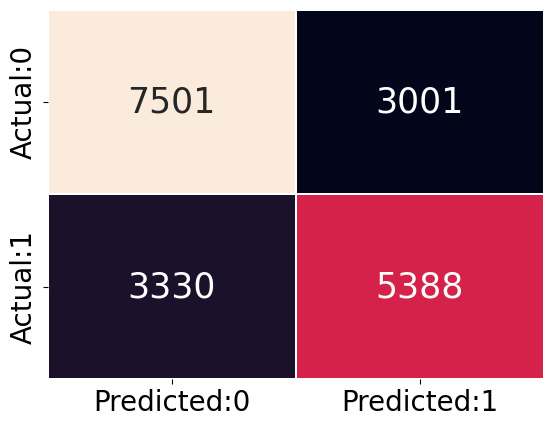

In [166]:
# Confusion Matrix
cm = confusion_matrix(ytest_cat, ypred_cat)
conf_matrix = pd.DataFrame(data=cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, linewidths=0.1, annot_kws={'size':25})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [167]:
# Classification Report
print(classification_report(ytest_cat, ypred_cat))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70     10502
           1       0.64      0.62      0.63      8718

    accuracy                           0.67     19220
   macro avg       0.67      0.67      0.67     19220
weighted avg       0.67      0.67      0.67     19220



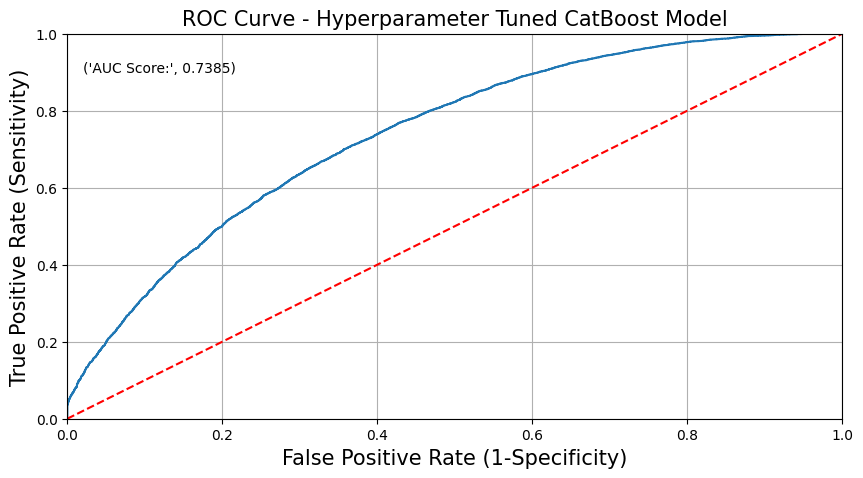

In [168]:
# ROC Curve
plt.figure(figsize=(10, 5))
fpr, tpr, thresholds = roc_curve(ytest_cat, ypred_proba_cat)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC Curve - Hyperparameter Tuned CatBoost Model', fontsize=15)
plt.xlabel('False Positive Rate (1-Specificity)', fontsize=15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=15)
plt.text(x=0.02, y=0.9, s=('AUC Score:', round(roc_auc_score(ytest_cat, ypred_proba_cat), 4)))
plt.grid(True)
plt.show()

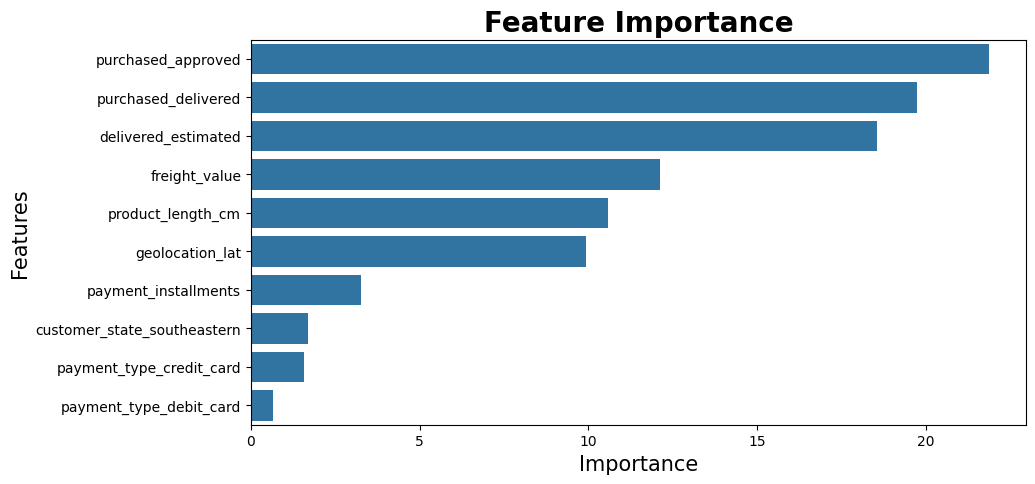

In [169]:
# Feature Importance
plt.figure(figsize=(10, 5))
important_features = pd.DataFrame({'Features': xtrain_cat.columns, 'Importance': catBoost.feature_importances_})
important_features = important_features.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Features', data=important_features)
plt.title('Feature Importance', color='black', fontsize=20, fontweight='bold')
plt.xlabel('Importance', color='black', fontsize=15)
plt.ylabel('Features', color='black', fontsize=15)
plt.show()

In [170]:
model_evaluation_tuned.loc['Tuned CatBoost Classifier'] = [
    accuracy_score(ytest_cat, ypred_cat), accuracy_score(ytrain_cat, ypred_cat_train),
    precision_score(ytest_cat, ypred_cat), precision_score(ytrain_cat, ypred_cat_train),
    recall_score(ytest_cat, ypred_cat), recall_score(ytrain_cat, ypred_cat_train),
    cohen_kappa_score(ytest_cat, ypred_cat), cohen_kappa_score(ytrain_cat, ypred_cat_train),
    f1_score(ytest_cat, ypred_cat), roc_auc_score(ytest_cat, ypred_proba_cat)
]

model_evaluation_tuned

,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_kappa,train_kappa,f1_score,roc_auc_score
Tuned XGBoost Classifier,0.654422,0.749662,0.625249,0.728011,0.608017,0.709452,0.302136,0.493220,0.616513,0.650737
Tuned LightGBM Classifier,0.665349,0.689643,0.638813,0.662173,0.615534,0.635314,0.323722,0.370864,0.626957,0.661393
Tuned CatBoost Classifier,0.670604,0.736186,0.642270,0.714737,0.618032,0.691565,0.333345,0.465802,0.629918,0.738538


### *Insight*

- Tuned CatBoost performs slightly worse than RFE CatBoost, with lower test accuracy (0.6706) but still reasonable precision and recall.
- XGBoost and LightGBM see only minor improvements, suggesting hyperparameter tuning didn't help much compared to feature selection.
- ROC AUC scores drop for all tuned models, meaning feature selection (RFE) was a more effective way to improve performance than hyperparameter tuning.

Feature selection (RFE) had a bigger impact on improving model performance than hyperparameter tuning.



## Conclusion and Recommendation

1. The original CatBoost model provides the best combination of accuracy, precision, recall, and AUC-ROC, making it the most effective model for churn classification.

Churn classification is a high-risk problem, where predicting customer retention vs. churn incorrectly can have significant business impacts. For this reason, the following metrics are critical:

- Test Accuracy (0.7557) → Indicates overall correctness in classifying customers as churners or non-churners.

- Test Precision (0.7402) → In churn classification, precision matters because it ensures that when we predict a customer will churn, we are right most of the time.
A high precision means fewer false positives, avoiding unnecessary interventions for non-churners.

- Test Recall (0.7108) → Recall is crucial because missing actual churners (false negatives) can be costly for the business.
A higher recall means we correctly identify more churners, allowing proactive retention strategies.

- ROC AUC (0.8392) → Measures the model’s ability to distinguish between churners and non-churners.
A higher ROC AUC means the model is highly effective at ranking churners over non-churners.

- Balanced Performance (F1-Score = 0.7252) → A good F1-score means the model balances precision and recall, making it reliable for real-world application.

2. Key Factors Influencing Churn
- Purchased Approved – Faster purchase approvals reduce churn, while delays increase the risk of customer dissatisfaction.
- Purchased Delivered – Timely deliveries enhance customer retention, while delays may push customers toward competitors.
- Delivered Estimated – Accurate delivery estimates are crucial, as late or incorrect estimates can lead to churn.
- Freight Value – High shipping costs discourage repeat purchases and impact customer loyalty.
- Product Length (cm) – Larger products may face shipping challenges, leading to potential delays.
- Geolocation (Latitude) – Customer location affects churn due to variations in delivery speed and service availability.
- Payment Installments – Customers using installment options tend to have higher engagement and lower churn.
- Payment Type (Credit/Debit Card) – Credit card users often show higher retention rates than debit card users.
- Customer State (Southeastern Region) – Regional differences impact churn, possibly due to service quality and economic factors.

3. To minimize customer churn and improve retention, businesses should focus on:

- Optimizing Approval and Delivery Processes: Reducing delays in order approvals and ensuring faster deliveries can enhance customer satisfaction and loyalty. Streamlining logistics operations and improving carrier partnerships can help achieve this.

- Reducing Shipping Costs: High freight charges deter repeat purchases. Offering free or discounted shipping for loyal customers, bulk orders, or subscription-based models can encourage retention.

- Enhancing Payment Flexibility: Customers using installment plans or credit card payments show higher engagement. Expanding flexible payment options, including installment plans and auto-renewal features, can boost retention rates.

- Improving Regional Logistics: Customer location affects churn, often due to delivery time variability. Establishing localized warehouses, optimizing last-mile delivery, and tailoring marketing efforts to high-churn regions can improve customer experience and reduce attrition.

# Model Extraction

In [160]:
import pickle

# Save the model
with open('catboost_model.pkl', 'wb') as f:
    pickle.dump(catBoost, f)

print("CatBoost model saved as 'catboost_model.pkl'")


CatBoost model saved as 'catboost_model.pkl'
